
<h1>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones<h1> 

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Practico 2:  Curación y Exploración de Datos

En la siguiente notebook, se desarrolla el segundo práctico de la materia Exploración y Curación. El objetivo consiste en identificar e implementar los pasos necesarios para la limpieza de la base de datos, así como también analizar cruces de datos con mayor profundidad y validando el sentido lógico.

### Importación de Librerías

In [56]:
import pyarrow
import fastparquet
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib as hl
import re

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer

from sklearn import (base, decomposition, feature_extraction, impute,
                     neighbors, preprocessing)
from sklearn.preprocessing import MinMaxScaler
from unidecode import unidecode

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

### Lectura del Dataset

In [57]:
df_orig = pd.read_parquet("cupones_ds.parquet")
df = df_orig.copy()

In [58]:
df

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo
0,0001686b52949b5461ffcbc766687e45031,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766.0,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia
1,000220fa96ec5af89817894033f8099c547,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521.0,GLLEN,2020-06-10,SIN DATOS,None,None
2,0002be202de47dfae9cc2304d91161be595,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107.0,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros
3,000e137d0af42e193be1ff670c00d4d1506,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Hombre,Argentina,SANTA FE,SAN LORENZO,2200.0,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia
4,0009d010e4faf69552a814a33832b185877,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019.0,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092072,00087cefbeb57961569988d7403d45a8135,0,30093930,TARJETA NARANJA TUCUMAN CRISOS,373205,0,PL,1,3,1,...,Mujer,Argentina,TUCUMAN,TUCUMAN,4000.0,MZ.3-TORRE A-24 DE SETIEMBRE-TUCUMAN,2016-01-06,SIN DATOS,SECUNDARIOS,None
4092073,0007e89e7180b18b18951a4c9de5419f943,0,30095787,TARJETA NARANJA SAN ISIDRO,210118,0,PL,1,22,1,...,Mujer,Argentina,BUENOS AIRES,OLIVOS (Buenos Aires),1636.0,VICENTE LOPEZ,2018-10-08,SIN DATOS,None,None
4092074,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,760582,0,PL,1,3,1,...,Mujer,Argentina,MENDOZA,GENERAL ALVEAR,5620.0,Y EVA DUARTE,2019-08-06,SIN DATOS,PRIMARIOS,Propia
4092075,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,761648,0,PL,1,3,1,...,Mujer,Argentina,MENDOZA,GENERAL ALVEAR,5620.0,Y EVA DUARTE,2019-08-06,SIN DATOS,PRIMARIOS,Propia


In [59]:
df['monto_compra_movimiento'].describe().round(2)

count    4092077.00
mean        1959.94
std         5814.49
min      -147263.64
25%           75.02
50%          301.29
75%         1476.00
max       220540.01
Name: monto_compra_movimiento, dtype: float64

In [60]:
df_orig.shape

(4092077, 41)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092077 entries, 0 to 4092076
Data columns (total 41 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   dni_titular_movimiento               object 
 1   moneda_movimiento                    int64  
 2   id_comercio_movimiento               int64  
 3   nombre_comercio_histo                object 
 4   numero_cupon_movimiento              int64  
 5   debito_credito_movimiento            int64  
 6   producto_naranja_movimiento          object 
 7   codigo_empresa_movimiento            int64  
 8   tipo_producto_tarjeta_movimiento     int64  
 9   plan_movimiento                      int64  
 10  fecha_vto_cupon_movimiento           object 
 11  fecha_presentacion_movimiento        object 
 12  fecha_cupon_movimiento               object 
 13  fecha_carga_sistema_movimiento       object 
 14  monto_compra_movimiento              float64
 15  importe_cuota_movimiento        

## 1. Curación

### Eliminar filas duplicadas

Observamos la presencia de filas duplicadas en el dataset original. La combinacion de algunas variables como dni + numero_cupon + monto_compra deberia ser unica

In [62]:
df[(df["numero_cupon_movimiento"] == 516404) & 
   (df["dni_titular_movimiento"] == "000c49ccbb959a141c075be6018d8652091")][['dni_titular_movimiento', 'numero_cupon_movimiento', 'monto_compra_movimiento']]

,dni_titular_movimiento,numero_cupon_movimiento,monto_compra_movimiento
34501,000c49ccbb959a141c075be6018d8652091,516404,9997.47
109478,000c49ccbb959a141c075be6018d8652091,516404,9997.47
170428,000c49ccbb959a141c075be6018d8652091,516404,9997.47
207632,000c49ccbb959a141c075be6018d8652091,516404,9997.47
324379,000c49ccbb959a141c075be6018d8652091,516404,9997.47
...,...,...,...
3801300,000c49ccbb959a141c075be6018d8652091,516404,9997.47
3849691,000c49ccbb959a141c075be6018d8652091,516404,9997.47
3892541,000c49ccbb959a141c075be6018d8652091,516404,9997.47
3988755,000c49ccbb959a141c075be6018d8652091,516404,9997.47


Existen 69 repeticiones para esta combinacion. Procedemos a eliminar los duplicados y repetimos la operacion anterior para verificar

In [63]:
df = df[~df.duplicated()]

In [64]:
df[(df["numero_cupon_movimiento"] == 516404) & 
   (df["dni_titular_movimiento"] == "000c49ccbb959a141c075be6018d8652091")][['dni_titular_movimiento', 'numero_cupon_movimiento', 'monto_compra_movimiento']]

,dni_titular_movimiento,numero_cupon_movimiento,monto_compra_movimiento
34501,000c49ccbb959a141c075be6018d8652091,516404,9997.47
109478,000c49ccbb959a141c075be6018d8652091,516404,9997.47


Todavia quedan duplicados por eliminar. Luego del proceso de curacion volveremos a aplicar este procedimiento para eliminar los que faltan. Veamos como cambio la variable a predecir.

In [65]:
df['monto_compra_movimiento'].describe().round(2)

count    124316.00
mean       1920.44
std        5746.73
min     -147263.64
25%          75.02
50%         301.29
75%        1400.00
max      220540.01
Name: monto_compra_movimiento, dtype: float64

### Ajuste por Inflación

Antes de iniciar la curación, se deben tener en cuenta dos factores importantes a la hora del análisis de los montos: El efecto de la inflación y el tipo de cambio.

Los consumos en pesos fueron efectuados durante un plazo que comprende varios meses. Por lo tanto, sumarlos en diferentes momentos temporales nos puede llevar a sacar conclusiones incorrectas. Para solucionar este inconveniente, obtuvimos los datos de inflación mensual de la fuente mencionada y aplicamos una operacion de deflactación sobre las diferentes filas afectadas. Elegimos como mes base, el mes de Febrero del 2020, llevando todos los movimientos a la moneda de ese mes.

Fuente: https://datosmacro.expansion.com/ipc-paises/argentina?sector=IPC+General&sc=IPC-IG&anio=2020

In [66]:
df_infl = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/DiploDatos_2021_Mentoria_Grupo_2/main/notebooks_tp2/Indices%20de%20inflaci%C3%B3n.csv', 
                      parse_dates=['mes'])

In [67]:
df_infl

,mes,inflacion_mensual,inflacion_acumulada
0,2020-02-01,0.000,0.000
1,2020-03-01,0.033,0.033
2,2020-04-01,0.015,0.048
3,2020-05-01,0.015,0.063
4,2020-06-01,0.022,0.085
5,2020-07-01,0.019,0.104
6,2020-08-01,0.027,0.131
7,2020-09-01,0.028,0.159
8,2020-10-01,0.038,0.197
9,2020-11-01,0.032,0.229


In [68]:
# Procedimiento para ajustar la variable monto a la inflacion en el periodo muestreado

df['anio_mes_cupon'] = pd.DatetimeIndex(df['fecha_cupon_movimiento']).year * 100 + pd.DatetimeIndex(df['fecha_cupon_movimiento']).month
df_infl['anio_mes_infl'] = pd.DatetimeIndex(df_infl['mes']).year * 100 + pd.DatetimeIndex(df_infl['mes']).month

df = df.merge(df_infl[['anio_mes_infl', 'inflacion_acumulada']]
         ,left_on='anio_mes_cupon'
         ,right_on='anio_mes_infl'
         ,how='inner').drop(columns=['anio_mes_infl'])
df.loc[df.moneda_movimiento != 1,'monto_ajustado'] = \
                df[df.moneda_movimiento != 1]['monto_compra_movimiento'] / (1 + df['inflacion_acumulada'])

<ipython-input-68-34b8218030ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anio_mes_cupon'] = pd.DatetimeIndex(df['fecha_cupon_movimiento']).year * 100 + pd.DatetimeIndex(df['fecha_cupon_movimiento']).month


In [69]:
# Visualizamos montos ajustados en pesos luego del ajuste
df.loc[df['moneda_movimiento'] != 1, ['monto_compra_movimiento','monto_ajustado']].describe().round(2)

,monto_compra_movimiento,monto_ajustado
count,122141.00,122141.00
mean,1954.59,1529.21
std,5791.92,4514.25
min,-147263.64,-123027.27
25%,75.02,59.23
50%,301.29,249.79
75%,1455.00,1136.82
max,220540.01,160281.96


### Ajuste por Tipo de Cambio

Fuente: https://www.bna.com.ar/ (Buscar historicos de cotizaciones)

Debido a que no se pueden sumar movimientos en diferentes divisas, decidimos aplicar el tipo de cambio vendedor a los consumos en dólares presentes en el dataset. Sabemos que Tarjeta Naranja aplica, para esta conversión, el tipo de cambio del dia del pago del resumen. Hicimos la suposición de que los clientes abonaron el resumen a su vencimiento, el día 10 (o el primer dia hábil siguiente) de cada mes.

Es necesario aclarar que el cierre de la tarjeta se da los dias 24 de cada mes. Por lo tanto, los movimientos efectuados luego de esa fecha se abonan al mes subsiguiente.

In [70]:
# Obtención de la cotizacion del dolar para los meses en nuestro dataset
df_tdc = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/DiploDatos_2021_Mentoria_Grupo_2/main/notebooks_tp2/Tipos%20de%20cambio.csv',
                     parse_dates=['fecha_cotizacion'], dayfirst=True, delimiter=';')

df_tdc = df_tdc.sort_values(by=['fecha_cotizacion']).reset_index(level=None).drop(columns=['index'])
df_tdc['anio_mes'] = (df_tdc.fecha_cotizacion.dt.year * 100) + df_tdc.fecha_cotizacion.dt.month
df_tdc.head(10)

,fecha_cotizacion,compra,venta,anio_mes
0,2020-02-10,58.00,63.00,202002
1,2020-02-11,58.25,63.25,202002
2,2020-02-12,58.25,63.25,202002
3,2020-02-13,58.25,63.25,202002
4,2020-02-14,58.25,63.25,202002
5,2020-02-17,58.25,63.25,202002
6,2020-02-18,58.25,63.25,202002
7,2020-02-19,58.50,63.50,202002
8,2020-02-20,58.50,63.50,202002
9,2020-02-21,58.50,63.50,202002


In [71]:
# Procedimiento para calcular la fecha de cotizacion 
df_tdc['day'] = df_tdc.fecha_cotizacion.dt.day

meses_cdiez = df_tdc[df_tdc['day'].isin([10])]['anio_mes'].unique()
meses_sdiez = df_tdc[(~df_tdc['day'].isin([10])) & (~df_tdc['anio_mes'].isin(meses_cdiez))]['anio_mes'].unique()

ind_fechas = []
for i in meses_cdiez:
    ind_fechas.append(min((df_tdc[(df_tdc['anio_mes'] == i) & (df_tdc['day'] == 10)]['fecha_cotizacion'].index)))
for i in meses_sdiez:
    ind_fechas.append(min((df_tdc[(df_tdc['anio_mes'] == i) & (df_tdc['day'] > 10)]['fecha_cotizacion'].index)))

In [72]:
# Cotizacion del dia y el dia de vencimiento
df_tdc_cot = df_tdc.iloc[ind_fechas,:].sort_values(by=['fecha_cotizacion']).reset_index(level=None).drop(columns=['index'])
df_tdc_cot

,fecha_cotizacion,compra,venta,anio_mes,day
0,2020-02-10,58.00,63.00,202002,10
1,2020-03-10,59.00,64.00,202003,10
2,2020-04-13,61.75,66.75,202004,13
3,2020-05-11,64.25,69.25,202005,11
4,2020-06-10,66.50,71.50,202006,10
5,2020-07-13,69.50,74.50,202007,13
6,2020-08-10,72.00,77.00,202008,10
7,2020-09-10,74.00,79.00,202009,10
8,2020-10-13,76.25,82.25,202010,13
9,2020-11-10,78.75,84.75,202011,10


In [73]:
# Procesamos la variable anio_mes_cupon considerando la fecha de corte
df.fecha_cupon_movimiento = pd.to_datetime(df.fecha_cupon_movimiento)

def func_var(row):
    if row.fecha_cupon_movimiento.day > 24:
        if row.fecha_cupon_movimiento.month == 12:
            return 202101
        else:
            return row['anio_mes_cupon'] + 1
    else:
        return row['anio_mes_cupon']

df.loc[df.moneda_movimiento == 1,'anio_mes_cupon'] = df[df.moneda_movimiento == 1].apply(func_var, axis=1)

Mostramos un ejemplo donde se puede visualizar que anio_mes_cupon cambia para antes y despues de la fecha de corte

In [74]:
df[(df.moneda_movimiento == 1) & (df.fecha_cupon_movimiento.dt.day >= 22)  & (df.fecha_cupon_movimiento.dt.month >= 12)][['fecha_cupon_movimiento','anio_mes_cupon']].head(7)

,fecha_cupon_movimiento,anio_mes_cupon
59942,2020-12-25,202101
59943,2020-12-27,202101
59945,2020-12-27,202101
59946,2020-12-23,202012
59953,2020-12-24,202012
59954,2020-12-31,202101
59967,2020-12-27,202101


In [75]:
# Mergeamos con df original
df = df.merge(df_tdc_cot[['anio_mes', 'venta']]
                 ,left_on='anio_mes_cupon'
                 ,right_on='anio_mes'
                 ,how='inner').drop(columns=['anio_mes'])

# Aplicamos el tipo de cambio
df.loc[df.moneda_movimiento == 1,'monto_ajustado'] = \
                df[df.moneda_movimiento == 1]['monto_compra_movimiento'] * df['venta']

# Se descartan las columnas usadas para los calculos
df = df.drop(columns=['inflacion_acumulada','venta'])

# Redondeamos
df['monto_ajustado'] = df['monto_ajustado'].round(2)

In [76]:
# Visualizamos montos ajustados en dolares luego de aplicar el tipo de cambio
df.loc[df['moneda_movimiento'] == 1, ['monto_compra_movimiento','monto_ajustado']].describe().round(2)

,monto_compra_movimiento,monto_ajustado
count,2175.00,2175.00
mean,3.02,251.37
std,25.53,2236.67
min,-200.23,-19822.77
25%,1.10,95.41
50%,2.71,234.63
75%,5.14,438.13
max,325.35,25702.65


------

### 1.1 Asegurar IDs únicos

El dataframe contiene una relacion 1:N correspondiente a **id_comercio** y a **nombre_comercio**. Estudiando casos donde esto ocurre, observamos que se debe a dos razones:
* Por un lado, los nombres pueden contener distintos caracteres especiales en cada caso. Por ejemplo:

In [77]:
df[df['nombre_comercio_histo'].str.contains('TARJETA NARANJA SUBTE')] \
                                        [['id_comercio_movimiento','nombre_comercio_histo']] \
                                        .drop_duplicates()

,id_comercio_movimiento,nombre_comercio_histo
2527,10099033,TARJETA NARANJA SUBTE
8513,10099033,TARJETA NARANJA SUBTE


* Por otro lado, un mismo **id_comercio** puede haber cambiado su razón social a lo largo del tiempo. Por ejemplo:

In [78]:
df[df['id_comercio_movimiento'] == 262002246][['id_comercio_movimiento',
                                               'nombre_comercio_histo']]

,id_comercio_movimiento,nombre_comercio_histo
6012,262002246,ATM CIA. DE SEGUROS
6013,262002246,ATM CIA. DE SEGUROS
6014,262002246,ATM CIA. DE SEGUROS
10060,262002246,ATMCIASEG
10061,262002246,ATMCIASEG
...,...,...
119973,262002246,ASEGURADORA TOTAL MOTOVEHICULA
119974,262002246,COMUNIDAD MOTOCICLISTA
119975,262002246,COMUNIDAD MOTOCICLISTA
120614,262002246,ASEGURADORA TOTAL MOTOVEHICULA


Para solventar estos problemas, se aplicó la funcion ´strip()´ que se encarga de eliminar los caracteres especiales. 
Para los casos donde hubo cambio de razón social, se concatenaron en una nueva columna **nombre_comercio_concat**. De esta manera se pierde la diferencia entre los distintos nombres asociados a ese id pero se gana la relacion 1:1 entre id y nombre.

In [79]:
# Reagrupar los comercios que tienen mas de un nombre y concatenar todos sus nombres
df.nombre_comercio_histo = df.nombre_comercio_histo.str.strip()

df_unicos = (
    df[["id_comercio_movimiento", "nombre_comercio_histo"]].drop_duplicates()\
        .groupby("id_comercio_movimiento").agg({"nombre_comercio_histo": 'sum'})
).reset_index()

df_unicos = df_unicos.rename(columns={'nombre_comercio_histo':'nombre_comercio_concat'})

Reagrupamos los comercios que tienen mas de un nombre y concatenamos todos sus nombres en una nueva columna **nombre_comercio_concat**

In [80]:
# Unimos con dataframe original agregando la columna nueva con relacion 1:1 con el id
df = df.merge(df_unicos.drop_duplicates(subset=['id_comercio_movimiento'], keep='first'), on='id_comercio_movimiento', how='inner')

# Relacion 1:1 entre id_comercio_movimiento y la columna nueva con los nombres concatenados
df[['id_comercio_movimiento', 'nombre_comercio_concat']].drop_duplicates() \
.groupby(['id_comercio_movimiento']).count() # Deberia dar 3833 que es la cantidad de ids unicos

,nombre_comercio_concat
id_comercio_movimiento,
10099033,1
10099058,1
10099814,1
20080001,1
20089993,1
...,...
991085968,1
991097830,1
991108260,1


Mostramos el ejemplo del id_comercio 262002246, donde tenemos 4 razones sociales asociadas a un mismo id, y el resultado luego de la transformación realizada.

In [81]:
df[df['id_comercio_movimiento'] == 262002246][['id_comercio_movimiento',
                                               'nombre_comercio_histo',
                                               'nombre_comercio_concat']]

,id_comercio_movimiento,nombre_comercio_histo,nombre_comercio_concat
108576,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
108577,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
108578,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
108579,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
108580,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
...,...,...,...
108671,262002246,ASEGURADORA TOTAL MOTOVEHICULA,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
108672,262002246,COMUNIDAD MOTOCICLISTA,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
108673,262002246,COMUNIDAD MOTOCICLISTA,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
108674,262002246,ASEGURADORA TOTAL MOTOVEHICULA,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...


### 1.2. Asegurar el tipo de dato de codigo postal

In [82]:
df['domicilio_codigo_postal'].dtype

dtype('float64')

En el dataset original la columna de **domicilio_codigo_postal** tiene un formato float64.
El código postal es un número, pero no se deberían de poder hacer cálculos sobre el mismo, por lo cual se la considera una variable Categórica, y se la convierte en String para quitarle los decimales y además, impedir que se puedan hacer cálculos sobre él.

In [83]:
df.domicilio_codigo_postal = df[df['domicilio_codigo_postal'].isna()!=True]['domicilio_codigo_postal'].apply(int).apply(str)
df.domicilio_codigo_postal = df.domicilio_codigo_postal.str.strip()

In [84]:
df['domicilio_codigo_postal'].dtype # O: Object, que aplica para strings

dtype('O')

In [85]:
df.domicilio_codigo_postal

0         1766
1         5521
2         7107
3         2200
4         1019
          ... 
124311    3503
124312    4200
124313    4200
124314    5300
124315    5300
Name: domicilio_codigo_postal, Length: 124316, dtype: object

### 1.3. Tratamiento de datos sensibles

Analizando el dataset, podemos observar que el único dato sensible es **dni_titular_movimiento**. Por lo tanto, codificamos los valores de esta columna usando el algoritmo SHA-256 con la libreria hashlib.

Debido a que esta columna ya estaba encriptada, aplicamos el algoritmo sobre una copia del dataframe original. 

In [86]:
df_testing_dni = df[:100].copy(deep=True)
df_testing_dni['dni_titular_movimiento'] = df_testing_dni['dni_titular_movimiento'].str.strip()
df_testing_dni['dni_titular_movimiento'] = [hl.sha256(val.encode("utf8")).hexdigest() for val in df_testing_dni['dni_titular_movimiento']]
df_testing_dni.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat
0,ab13f4e1b1c8194051b1dd6da7643b6863500750713f8e...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,LA TABLADA,1766,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia,202008,5.52,INTERES POR MORA U$S
1,e77952e42b7136528a7169e75706a24427288b34df5d5c...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,VA.NVA. DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,None,None,202008,15.68,INTERES POR MORA U$S
2,d3a2291efdc4b3d6eb1b521e6b945c279b37669f36add0...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,202008,5.46,INTERES POR MORA U$S
3,ac9b1c68c368d72d18332dee7a9c022ca1f568d9d33962...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia,202008,2.50,INTERES POR MORA U$S
4,7761d75e3579c455c20a7156cfc10b68c4acc37fe6b5cc...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,...,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada,202008,2.10,INTERES POR MORA U$S


### 1.4. Reemplazar caracteres especiales

Esta transformación se aplica sobre las columnas que tienen strings. Aplicamos dos tecnicas para eliminar los caracteres especiales. Por un lado usamos unidecode para unificar el texto y corregir caracteres como la Ñ; y por otro lado aplicamos una expresion regular para eliminar espacios y otros caracteres especiales.

In [87]:
# Columnas que contienen strings
columnas_str = [
    'nombre_comercio_histo',
    'producto_naranja_movimiento',
    'nombre_local_histo',
    'estado_civil_descripcion',
    'sexo_descripcion',
    'pais',
    'provincia',
    'ciudad',
    'domicilio_barrio',
    'cargo_descripcion_histo',
    'nivel_estudio_descripcion_histo',
    'rel_vivienda_descripcion_histo',
    'nombre_comercio_concat'
]

In [88]:
# Expresion regular que incluye solo caracteres de a-z mayúscula o minúscula y 0-9
regex = r'[^a-zA-Z0-9 ]'

In [89]:
unidecode(u'Ñ')

'N'

In [90]:
# Visualización de algunos ejemplos antes de corregir
print(df.loc[df['id_comercio_movimiento'] == 40111133]['nombre_comercio_histo'].head(1))
print(df.loc[df['id_comercio_movimiento'] == 78199230]['nombre_comercio_histo'].head(1))

45713    P.E.S BANELCO TN
Name: nombre_comercio_histo, dtype: object
124118    TASI 1- ROSARIO SUR
Name: nombre_comercio_histo, dtype: object


In [91]:
for col in columnas_str:
    df[col] = df[df[col].isnull()==False][col].apply(unidecode)

In [92]:
for col in columnas_str:
    df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')

<ipython-input-92-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')
<ipython-input-92-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')
<ipython-input-92-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')
<ipython-input-92-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')
<ipython-input-92-6865719e0677>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[df[col].isnull()==False][col].str

In [93]:
print(df.loc[df['id_comercio_movimiento'] == 40111133]['nombre_comercio_histo'].head(1))
print(df.loc[df['id_comercio_movimiento'] == 78199230]['nombre_comercio_histo'].head(1))

45713    PES BANELCO TN
Name: nombre_comercio_histo, dtype: object
124118    TASI 1 ROSARIO SUR
Name: nombre_comercio_histo, dtype: object


### 1.5. Asegurar formato de fecha

Para asegurar el formato fecha, usamos la funcion datetime de Python

In [94]:
# Columnas con fecha

col_fechas = [
    'fecha_vto_cupon_movimiento',
    'fecha_presentacion_movimiento',
    'fecha_cupon_movimiento',
    'fecha_carga_sistema_movimiento',
    'fecha_nacimiento',
    'fecha_extraccion_movimiento',
    'fecha_de_ingreso_histo'
]

In [95]:
df[col_fechas].isnull().sum()

fecha_vto_cupon_movimiento             0
fecha_presentacion_movimiento          0
fecha_cupon_movimiento                 0
fecha_carga_sistema_movimiento     40715
fecha_nacimiento                     306
fecha_extraccion_movimiento       124316
fecha_de_ingreso_histo                 0
dtype: int64

In [96]:
df[col_fechas] = df[col_fechas].apply(pd.to_datetime)

In [97]:
df["fecha_cupon_movimiento"]

0        2020-08-25
1        2020-08-25
2        2020-08-25
3        2020-08-25
4        2020-08-25
            ...    
124311   2021-05-14
124312   2021-05-03
124313   2021-05-03
124314   2020-02-16
124315   2020-02-16
Name: fecha_cupon_movimiento, Length: 124316, dtype: datetime64[ns]

### 1.6. Agrupar valores de cargo_descripcion_histo

In [98]:
df['cargo_descripcion_histo'].unique()

array(['EMPDE COMERCIO', 'SIN DATOS', 'ENFERMERO', 'INDEPENDIENTE',
       'EMPSEGPUBLICA', 'DOCENTE', 'ADMINISTRATIVO', 'VIGILADOR',
       'OPERARIO', 'MAESTRANZA', 'PROPIETARIO', 'ENCARGADO',
       'VENDEDORPROMOT', 'CHOFER', 'JUBILADO', 'PEONEMBARCADOS',
       'PRESTCREDITO', 'PROFESTECNICO', 'MOZO', 'CAJERO',
       'PORTEROCONSERJ', 'JEFE', 'PRESGARANTIA', 'COCINERO', 'MEDICO'],
      dtype=object)

In [99]:
df[['cargo_descripcion_histo']].groupby(by=['cargo_descripcion_histo']).size().to_frame()

,0
cargo_descripcion_histo,
ADMINISTRATIVO,6114
CAJERO,507
CHOFER,1151
COCINERO,82
DOCENTE,7154
EMPDE COMERCIO,15381
EMPSEGPUBLICA,3283
ENCARGADO,283
ENFERMERO,420


Decidimos reagrupar en las siguientes categorías:
* Sector Salud: Enfermero, Medico.
* Sector Educativo: Docente, Profestecnico
* Sector Seguridad: EmpSegPublica, PorteroConserj, Vigilador
* Sector Financiero: PRESGARANTIA, PRESTCREDITO
* Sector Gastronómico: Cocinero, Mozo
* Sector Comercio: Administrativo, Cajero, EMPDE COMERCIO, Maestranza, Jefe, Encargado, VENDEDORPROMOT
* Sector Operativo: Chofer, Independiente, Operario, PEONEMBARCADOS, Propietario.
* Sector No Operativo: Jubilados.
* Sin Datos: Sin Datos.

A los efectos de tener un numero representativo de casos dentro de cada categoria, decidimos incluir al sector Gastronomico dentro de Comercio.

In [100]:
sec_salud = ['ENFERMERO','MEDICO']
sec_edu = ['DOCENTE','PROFESTECNICO']
sec_seg = ['EMPSEGPUBLICA','PORTEROCONSERJ','VIGILADOR']
sec_fin = ['PRESGARANTIA','PRESTCREDITO']
sec_Emp_Com = ['ADMINISTRATIVO','CAJERO','EMPDE COMERCIO','MAESTRANZA','JEFE','ENCARGADO','VENDEDORPROMOT', 'COCINERO','MOZO']
sec_ope = ['CHOFER','INDEPENDIENTE','OPERARIO','PEONEMBARCADOS','PROPIETARIO']
sec_no_ope = ['JUBILADO']
sec_sd = ['SIN DATOS']

df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_salud)),'cargo_sector_desc_hist'] = 'Sector_Salud'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_edu)),'cargo_sector_desc_hist'] = 'Sector_Educativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_seg)),'cargo_sector_desc_hist'] = 'Sector_Seguridad'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_fin)),'cargo_sector_desc_hist'] = 'Sector_Financiero'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_Emp_Com)),'cargo_sector_desc_hist'] = 'Sector_Empleado_Comercio'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_ope)),'cargo_sector_desc_hist'] = 'Sector_Operativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_no_ope)),'cargo_sector_desc_hist'] = 'Sector_No_Operativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_sd)),'cargo_sector_desc_hist'] = 'Sector_Sin_Datos'

In [101]:
df[['cargo_descripcion_histo','cargo_sector_desc_hist']].drop_duplicates()

,cargo_descripcion_histo,cargo_sector_desc_hist
0,EMPDE COMERCIO,Sector_Empleado_Comercio
1,SIN DATOS,Sector_Sin_Datos
6,ENFERMERO,Sector_Salud
16,INDEPENDIENTE,Sector_Operativo
26,EMPSEGPUBLICA,Sector_Seguridad
36,DOCENTE,Sector_Educativo
39,ADMINISTRATIVO,Sector_Empleado_Comercio
54,VIGILADOR,Sector_Seguridad
81,OPERARIO,Sector_Operativo
83,MAESTRANZA,Sector_Empleado_Comercio


In [102]:
df[['cargo_sector_desc_hist']].groupby(by=['cargo_sector_desc_hist']).size().to_frame().sort_values(by=0, ascending=False)

,0
cargo_sector_desc_hist,
Sector_Sin_Datos,61613
Sector_Empleado_Comercio,26336
Sector_Operativo,11037
Sector_No_Operativo,10715
Sector_Educativo,8519
Sector_Seguridad,3752
Sector_Financiero,1904
Sector_Salud,440


-----

## 2 Data Enrichment

### 2.1. Cálculo de la edad de la persona

El cálculo de la edad se debe efectuar con las columnas **fecha_nacimiento** y **fecha_cupon_movimiento**. Sin embargo, para evitar tener clientes que cambien su edad, nos quedamos con la edad máxima del mismo. 

In [103]:
df['edad_cliente'] = ((df['fecha_cupon_movimiento'].max() - df['fecha_nacimiento'])/np.timedelta64(1, 'Y')).round(0)
df.edad_cliente = df.edad_cliente.astype('Int64', errors='ignore')

In [104]:
df.edad_cliente.describe().round(2)

count    124010.00
mean         50.09
std          15.11
min          19.00
25%          37.00
50%          48.00
75%          62.00
max         110.00
Name: edad_cliente, dtype: float64

Los casos nulos corresponden a clientes sin datos de fecha de nacimiento. Esto sera tratado en el apartado de analisis de datos nulos.

In [105]:
df.edad_cliente.isna().sum()

306

### 2.2 Cálculo de la antigüedad de la persona

El cálculo de la antigüedad del cliente se debe realizar con las columnas **fecha_cupon_movimiento** y **fecha_de_ingreso_histo**

In [106]:
df['antig_cliente']= ((df['fecha_cupon_movimiento'] - df['fecha_de_ingreso_histo'])/np.timedelta64(1, 'M'))
df['antig_cliente']= df.antig_cliente.apply(np.round).apply(int)
df[['fecha_cupon_movimiento', 'fecha_de_ingreso_histo', 'antig_cliente']]

,fecha_cupon_movimiento,fecha_de_ingreso_histo,antig_cliente
0,2020-08-25,2012-12-11,92
1,2020-08-25,2020-06-10,2
2,2020-08-25,2012-09-13,95
3,2020-08-25,2008-01-15,151
4,2020-08-25,2013-06-06,87
...,...,...,...
124311,2021-05-14,2012-08-02,105
124312,2021-05-03,2009-08-19,140
124313,2021-05-03,2009-08-19,140
124314,2020-02-16,1998-05-26,261


In [107]:
df.antig_cliente.describe().round(2)

count    124316.00
mean        113.51
std          79.12
min           0.00
25%          48.00
50%          98.00
75%         169.00
max         390.00
Name: antig_cliente, dtype: float64

### 2.3 Reagrupamiento de **nombre_comercio_histo**

Agrupamos la columna **nombre_comercio_histo** utilizando el primer dígito de **id_comercio_movimiento**. Usamos este criterio teniendo en cuenta el enfoque que usa Naranja para agrupar los comercios. Esto da como resultado 10 categorias.

In [108]:
df.id_comercio_movimiento = df.id_comercio_movimiento.astype(str)

In [109]:
df['id_comercio_movimiento'].str.len().value_counts()

9    66557
8    57759
Name: id_comercio_movimiento, dtype: int64

In [110]:
df['id_comercio_movimiento'] = df['id_comercio_movimiento'].str.zfill(9) # Se agrega el 0 a la izquierda

df['id_comercio_movimiento'].str.len().value_counts()

9    124316
Name: id_comercio_movimiento, dtype: int64

In [111]:
# Categorización
def func(row):
    return row.id_comercio_movimiento[0:1]

df['comercio_cat'] = df.apply(func, axis=1)

In [112]:
# Visualizar la columna de comercios recategorizada, segun cuantos id_comercios y cuantas transacciones se abarcan.
df_comercios = df['comercio_cat'].value_counts().to_frame().reset_index().rename(
                                    {'index':'comercio_cat',
                                     'comercio_cat':'frecuencia_ts'}, axis=1)

df_com_freq = pd.DataFrame(df.groupby(['comercio_cat'])['id_comercio_movimiento'].nunique().sort_values(ascending=True)) \
                            .reset_index().rename({
                                'id_comercio_movimiento':'frecuencia_idcom'
                            }, axis=1)
df_com_freq = df_com_freq.merge(df_comercios, on='comercio_cat', how='inner')
df_com_freq

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_com_freq.sort_values(by='frecuencia_idcom'))

  comercio_cat  frecuencia_idcom  frecuencia_ts
0            4                46            171
1            7                91            351
2            8               135            741
3            9               154          17131
4            6               248           1774
5            2               288           4097
6            0               326          57759
7            3               389           2429
8            5               826          12784
9            1              1330          27079


**comercio_cat** son las nuevas categorias; **frecuencia_idcom** es la cantidad de comercios que comprende cada categoria; y **frecuencia_ts** es la cantidad de transacciones en cada categoria.

Ademas de haber obtenido una categorizacion poco balanceada, creemos que esta agrupación podría estar uniendo comercios de distinta indole. Llegado el momento de entrenar un modelo de ML, se volverá a evaluar si esta categorización ha sido realizada de manera correcta, o si es necesario aplicar otro criterio para reagrupar. 

### 2.4 Consideración para reagrupar columnas **nombre_local_histo** y **cargo_descripcion_histo**

In [113]:
print('Porcentaje de valores nulos en nombre_local_histo:', "{:.0%}".format(df.nombre_local_histo.isna().sum() / len(df)))

Porcentaje de valores nulos en nombre_local_histo: 95%


Respecto de la columna **nombre_local_histo**, podemos observar que tiene un alto porcentaje de valores en nulo (94%), por lo cual no se justifica realizar un reagrupamiento sobre la misma.

La columna **cargo_descripcion_histo** fue reagrupada en el punto 1.6

-----

### Exportación de dataset para práctico 5 de Aprendizaje No Supervisado

In [114]:
df.to_parquet('cupones_no_supervisado.parquet')

### 3.1 Análisis e imputación de Datos Nulos

In [60]:
missing_values_count = df.isna().sum()
missing_values_count

dni_titular_movimiento                      0
moneda_movimiento                           0
id_comercio_movimiento                      0
nombre_comercio_histo                       0
numero_cupon_movimiento                     0
debito_credito_movimiento                   0
producto_naranja_movimiento                 0
codigo_empresa_movimiento                   0
tipo_producto_tarjeta_movimiento            0
plan_movimiento                             0
fecha_vto_cupon_movimiento                  0
fecha_presentacion_movimiento               0
fecha_cupon_movimiento                      0
fecha_carga_sistema_movimiento          40715
monto_compra_movimiento                     0
importe_cuota_movimiento                    0
interes_movimiento                          0
cargo_adm_seguro_movimiento                 0
cargo_otorgamiento_movimiento               0
cargo_seguro_vida_movimiento                0
cargo_administrativo_movimiento             0
seleccionado_ng                   

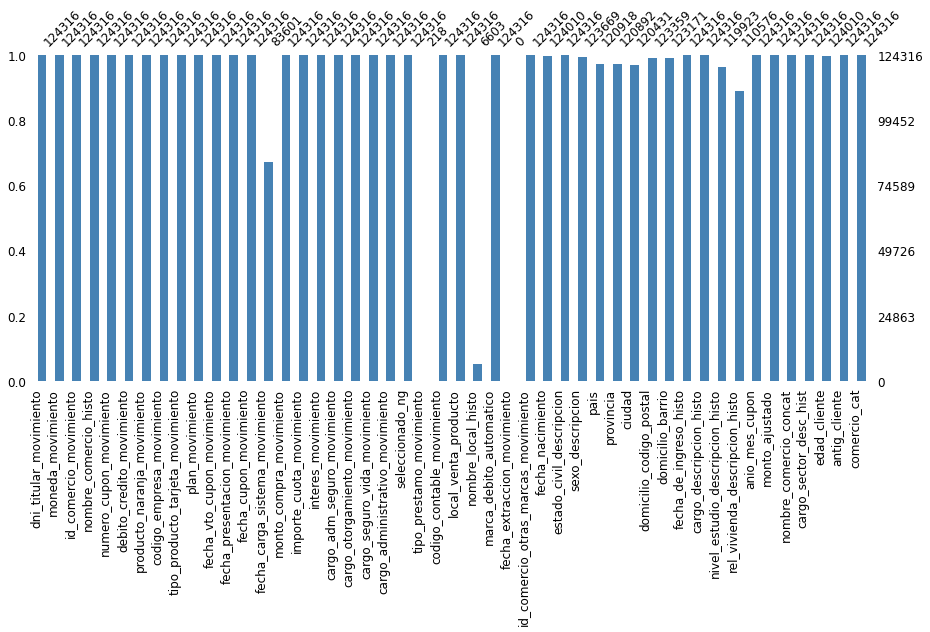

In [61]:
ax = msno.bar(df,figsize=(15, 6), fontsize=12, color='steelblue')
ax.tick_params('x', rotation=90)

In [62]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print('Porcentaje de valores en nulo:',"{:.0%}".format(total_missing/total_cells))

Porcentaje de valores en nulo: 7%


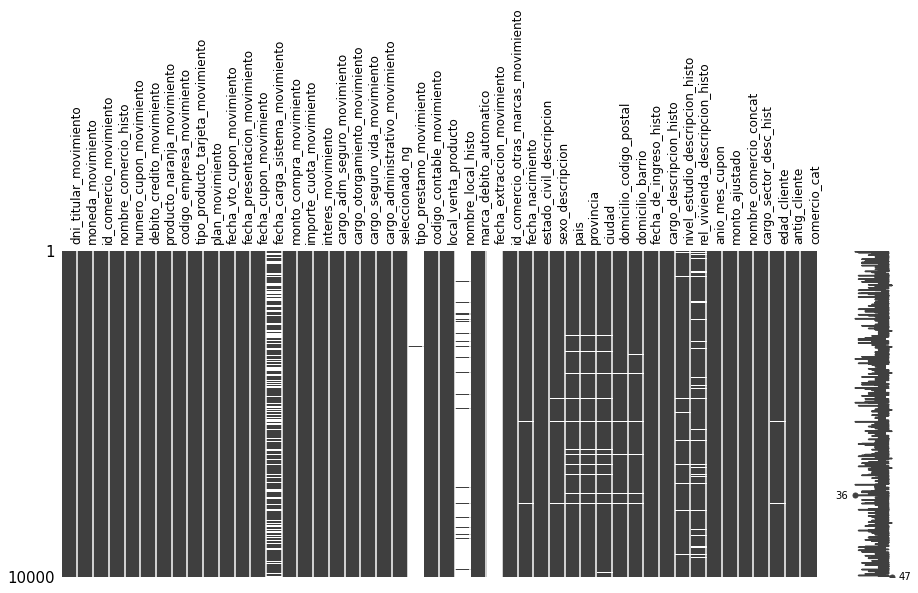

In [63]:
#usamos sample porque da error con todo el datas
df_ms = df.sample(10000)
ax = msno.matrix(df_ms,figsize=(15, 6),fontsize=12)
ax.tick_params('x', rotation=90)

Se puede observar cierta sistematicidad en la pérdida de valores relacionados a datos personales de los clientes. A continuación procedemos a analizar cada columna con valores faltantes.

#### Fecha carga sistema movimiento

In [64]:
print('fecha_cupon vs fecha_carga:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df["fecha_carga_sistema_movimiento"].dt.date, method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_carga:


0.9984405676446135

A la hora de evaluar la imputación de valores nulos en esta columna, decidimos, en primer lugar, considerar la utilidad que podriamos llegar a darle en un futuro. Al calcular su correlación con la columna **fecha_cupon_movimiento**, podemos observar que tienen una relación lineal fuerte, por lo cual decidimos no tener en cuenta esta columna para analisis posteriores, y si utilizar fecha_cupon_movimiento en su lugar.

In [65]:
df.drop('fecha_carga_sistema_movimiento', axis=1, inplace=True)

#### Tipo_prestamo_movimiento, Nombre_local_histo y Fecha_extraccion_movimiento 

Las variables tipo_prestamo_movimiento, nombre_local_histo y fecha_extraccion_movimiento poseen una gran cantidad de valores nulos (fecha extracción tiene todos sus valores nulos), por lo cuál la mejor decisión es no tenerlas en cuenta en los siguientes análisis.

In [66]:
df.drop(columns = ['tipo_prestamo_movimiento','nombre_local_histo','fecha_extraccion_movimiento'], inplace=True)

#### Datos Faltantes Personales de los clientes

In [67]:
col_pers = ['fecha_nacimiento', 'pais', 'domicilio_codigo_postal', 'sexo_descripcion',
           'provincia', 'dni_titular_movimiento', 'ciudad', 'edad_cliente', 'domicilio_barrio']

In [68]:
df_faltante_fech= pd.DataFrame(df[df['fecha_nacimiento'].isna()])
df_faltante_fech[col_pers].isna().sum()

fecha_nacimiento           306
pais                       306
domicilio_codigo_postal    306
sexo_descripcion           306
provincia                  306
dni_titular_movimiento       0
ciudad                     306
edad_cliente               306
domicilio_barrio           306
dtype: int64

In [69]:
df_faltante_fech.dni_titular_movimiento.value_counts()

000cde1ad5d8114e7a5dd977930b8835659    246
000650e8144e3a42d47a21aee9e48f34804     40
000b0d85fa8a959e2133328830fff990443     20
Name: dni_titular_movimiento, dtype: int64

In [70]:
df_falt = df_faltante_fech.dni_titular_movimiento.values
df[(df['dni_titular_movimiento'].isin(df_falt)) & (~df['fecha_nacimiento'].isnull())]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


Se observa que son 3 los clientes que tienen valores faltantes en las columnas fecha_nacimiento, sexo_descripcion, pais, provincia, ciudad, domicilio_codigo_postal y domicilio_barrio. Corresponden a información personal de los mismos, que no puede ser recuperada de otra forma. Es una pérdida sistemática NMAR.

A continuación visualizamos aquellos casos a los cuales les falta el dato del Sexo. 

In [71]:
df_faltante_sexo = pd.DataFrame(df[df['sexo_descripcion'].isna()])
df_faltante_sexo[col_pers].isna().sum()

fecha_nacimiento           306
pais                       324
domicilio_codigo_postal    306
sexo_descripcion           647
provincia                  324
dni_titular_movimiento       0
ciudad                     324
edad_cliente               306
domicilio_barrio           306
dtype: int64

In [72]:
df_falt = df_faltante_sexo.dni_titular_movimiento.values
df[(df['dni_titular_movimiento'].isin(df_falt)) & (~df['sexo_descripcion'].isnull())]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


Podemos decir que el resto de los dni a los que les falta el dato de sexo_descripcion tambien corresponden a una perdida sistemática, no pudiendose recuperar dicho dato.

Procedemos a imputar con 'Sin Datos' a los valores faltantes en la columna sexo_descripcion.

In [73]:
columna = ['sexo_descripcion']
#df['sexo_descripcion']= df.sexo_descripcion.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= np.nan, strategy='constant',fill_value="Sin Datos") 
df.loc[ : , columna] = pd.DataFrame(const_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [74]:
#df['sexo_descripcion'] = df['sexo_descripcion'].astype(str)
df['sexo_descripcion'].value_counts()

Mujer        65541
Hombre       58128
Sin Datos      647
Name: sexo_descripcion, dtype: int64

##### Datos faltantes Nivel de Estudio

In [75]:
df.nivel_estudio_descripcion_histo.value_counts()

SECUNDARIOS       66356
PRIMARIOS         30472
TERCIARIOS        14332
UNIVERSITARIOS     8763
Name: nivel_estudio_descripcion_histo, dtype: int64

In [76]:
columna = ['nivel_estudio_descripcion_histo']
df_faltante_estud = pd.DataFrame(df[df['nivel_estudio_descripcion_histo'].isna()])
df_faltante_estud[columna].isna().sum()

nivel_estudio_descripcion_histo    4393
dtype: int64

In [77]:
dnis_faltantes = df_faltante_estud.dni_titular_movimiento.values
df[(df['dni_titular_movimiento'].isin(dnis_faltantes)) & (~df['nivel_estudio_descripcion_histo'].isnull())]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


Observamos que la pérdida de datos de nivel de estudio también es sistemática, no pudiendose recuperar este dato, procedemos a imputar dichas filas con Sin datos. 

In [78]:
columna = ['nivel_estudio_descripcion_histo']
#df['sexo_descripcion']= df.sexo_descripcion.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= np.nan, strategy='constant',fill_value="Sin Datos") 
df.loc[ : , columna] = pd.DataFrame(const_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [79]:
df.nivel_estudio_descripcion_histo.value_counts()

SECUNDARIOS       66356
PRIMARIOS         30472
TERCIARIOS        14332
UNIVERSITARIOS     8763
Sin Datos          4393
Name: nivel_estudio_descripcion_histo, dtype: int64

##### Datos faltantes Vivienda

In [80]:
df.rel_vivienda_descripcion_histo.value_counts()

Propia         85313
Otros          10653
De familiar    10473
Alquilada       4137
Name: rel_vivienda_descripcion_histo, dtype: int64

In [81]:
columna = ['rel_vivienda_descripcion_histo']
df_faltante_vivi = pd.DataFrame(df[df['rel_vivienda_descripcion_histo'].isna()])
df_faltante_vivi[columna].isna().sum()

rel_vivienda_descripcion_histo    13740
dtype: int64

In [82]:
dnis_faltantes = df_faltante_vivi.dni_titular_movimiento.values
df[(df['dni_titular_movimiento'].isin(dnis_faltantes)) & (~df['rel_vivienda_descripcion_histo'].isnull())]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


In [83]:
columna = ['rel_vivienda_descripcion_histo']
#df["nivel_estudio_descripcion_histo"]= df.nivel_estudio_descripcion_histo.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= np.nan, strategy='constant',fill_value="Sin Datos") 
df.loc[ : , columna] = pd.DataFrame(const_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [84]:
df.rel_vivienda_descripcion_histo.value_counts()

Propia         85313
Sin Datos      13740
Otros          10653
De familiar    10473
Alquilada       4137
Name: rel_vivienda_descripcion_histo, dtype: int64

##### Datos faltantes Edad

Procedemos a imputar usando IterativeImputer (en su operación por defecto BayesianRigde) la variable edad_cliente. Para imputar usamos las columnas **edad_cliente** y **antig_cliente**.

In [85]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp_columns = ['edad_cliente', 'antig_cliente']
x_train = df[imp_columns]
imp.fit(x_train)

x_test = df[imp_columns]
x_test = np.round(imp.transform(x_test))
x_test = pd.DataFrame(x_test, columns=imp_columns)
x_test

,edad_cliente,antig_cliente
0,61.0,92.0
1,29.0,2.0
2,28.0,95.0
3,40.0,151.0
4,36.0,87.0
...,...,...
124311,66.0,105.0
124312,74.0,140.0
124313,74.0,140.0
124314,45.0,261.0


In [86]:
df['edad_cliente'] = x_test['edad_cliente']

In [87]:
df['edad_cliente'].describe().round(2)

count    124316.00
mean         49.68
std          15.08
min          19.00
25%          37.00
50%          47.00
75%          62.00
max         110.00
Name: edad_cliente, dtype: float64

La columna fecha_nacimiento se deja sin imputar debido a que su unica finalidad era obtener la edad del cliente. Por lo tanto, no se tiene en cuenta.

In [88]:
df.drop('fecha_nacimiento', inplace=True, axis=1)

#### Datos Faltantes Geograficos de los clientes

##### Sistematicidad en la pérdida

In [89]:
col_geo = ['domicilio_codigo_postal', 'pais', 'provincia', 'ciudad', 'domicilio_barrio']
df[df['domicilio_codigo_postal'].isna()][col_geo].isna().sum()

domicilio_codigo_postal    957
pais                       957
provincia                  957
ciudad                     957
domicilio_barrio           957
dtype: int64

In [90]:
dni_falt = df[df['domicilio_codigo_postal'].isna()].dni_titular_movimiento.values
df[(df['dni_titular_movimiento'].isin(dni_falt)) & (~df['domicilio_codigo_postal'].isnull())]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


Podemos decir que los dni a los que les faltan todos sus datos geográficos corresponden también a una pérdida sistemática, la cual no se puede recuperar. 

##### Reimputación con datos geográficos presentes

Intentaremos recuperar las filas donde haya algún dato geográfico presente que permita imputar los faltantes. Para esto, observamos la cantidad de provincias en nuestro dataframe.

In [91]:
pd.DataFrame({'Provincias': df['provincia'].unique()})\
    .sort_values(by='Provincias',ascending=True)\
    .reset_index().drop(columns=['index'])

,Provincias
0,BUENOS AIRES
1,CAPITAL FEDERAL
2,CATAMARCA
3,CHACO
4,CHUBUT
5,CORDOBA
6,CORRIENTES
7,ENTRE RIOS
8,FORMOSA
9,JUJUY


Tenemos un total de 24 provincias, el resto son registros NaN.

In [92]:
df[df['domicilio_codigo_postal'].str.len()<4][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

,pais,provincia,ciudad,domicilio_codigo_postal
24863,Argentina,NaN,NaN,0
58603,Argentina,TUCUMAN,CAMPO HERRERA,400


Observamos que tenemos datos erróneos de código postal con valores de 0 y 400. 

Analizaremos si podemos recuperar el código postal de la localidad de **Campo Herrera**. El Código Postal en 0 lo imputaremos por NaN.

In [93]:
print('Cantidad de filas con Cero:', len(df[df['domicilio_codigo_postal']=='0']))

Cantidad de filas con Cero: 26


In [94]:
df['domicilio_codigo_postal'] = df['domicilio_codigo_postal'].replace('0',np.nan)
df[df['domicilio_codigo_postal']=='0']

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


In [95]:
df['ciudad'] = df['ciudad'].str.strip()
print('Cantidad de filas con 400 en el CP:',len(df[df['ciudad'].isin(['CAMPO HERRERA'])]))
df[df['ciudad'].isin(['CAMPO HERRERA'])][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

Cantidad de filas con 400 en el CP: 20


,pais,provincia,ciudad,domicilio_codigo_postal
58603,Argentina,TUCUMAN,CAMPO HERRERA,400


Obteniendo el dato de una fuente externa, vamos a reemplazar el código postal de la ciudad Campo Herrera en la provincia Tucumán por el valor correcto.

Fuente: https://codigo-postal.co/argentina/tucuman/campo-herrera/

In [96]:
df.loc[df['ciudad'].isin(['CAMPO HERRERA']),'domicilio_codigo_postal'] = '4105'
print('Cantidad de filas con 400 en el CP:',len(df[df['ciudad'].isin(['CAMPO HERRERA'])]))
df[df['ciudad'].isin(['CAMPO HERRERA'])][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

Cantidad de filas con 400 en el CP: 20


,pais,provincia,ciudad,domicilio_codigo_postal
58603,Argentina,TUCUMAN,CAMPO HERRERA,4105


In [97]:
df[df['pais'].isnull()][['pais','provincia','ciudad','domicilio_codigo_postal','domicilio_barrio']].isna().sum()

pais                       3398
provincia                  3398
ciudad                     3398
domicilio_codigo_postal     957
domicilio_barrio            957
dtype: int64

Observamos que cuando **pais** es nulo, tambien lo son las variables **provincia** y **ciudad**. Primero vemos si existen datos dentro del dataset con los cuales imputar. 

In [98]:
df[(df['domicilio_codigo_postal'].isna()==True) & (df['ciudad'].isna()!=True)]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


In [99]:
df[(df['domicilio_codigo_postal'].isna()==True) & (df['provincia'].isna()!=True)]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


No es posible recuperar el código postal a través de las variables **provincia** o **ciudad**.

In [100]:
df[(df['domicilio_codigo_postal'].isna()!=True) & (df['ciudad'].isna()==True)][['domicilio_codigo_postal','ciudad']].drop_duplicates()

,domicilio_codigo_postal,ciudad
77,4400,NaN
128,5000,NaN
217,5501,NaN
494,5101,NaN
1481,5613,NaN
1527,5800,NaN
2111,4146,NaN
2271,2144,NaN
2411,5907,NaN
2687,1663,NaN


Sin embargo, analizaremos si podemos recuperar los datos de **provincia** y **ciudad** a través de **domicilio_codigo_postal** dentro de nuestro dataset.

In [101]:
cp_ciu_nan = df[(df['domicilio_codigo_postal'].isna()!=True) & (df['ciudad'].isna()==True)]['domicilio_codigo_postal'].unique()
df[df['domicilio_codigo_postal'].isin(cp_ciu_nan)][['domicilio_codigo_postal','ciudad']]\
.drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,ciudad
5899,1130,NaN
3027,1663,SAN MIGUEL
2687,1663,NaN
2271,2144,NaN
58610,2506,NaN
58684,2705,NaN
17839,2812,NaN
23486,3230,NaN
58620,3240,NaN
116,3300,POSADAS


In [102]:
df.loc[:,'ciudad'] = df['ciudad'].str.upper()
df_dp_cd = df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['ciudad'].isna()==False)]\
            [['domicilio_codigo_postal','ciudad']]\
            .drop_duplicates()\
            .sort_values(by=['domicilio_codigo_postal'])
df_dp_cd = df_dp_cd.rename(columns={'ciudad': 'ciudad_0', 'domicilio_codigo_postal': 'cp'})
df_dp_cd

,cp,ciudad_0
3027,1663,SAN MIGUEL
116,3300,POSADAS
26,3500,RESISTENCIA
870,3503,LA LEONESA
105,4000,SAN MIGUEL DE TUCUMAN
2024,4000,TUCUMAN
174,4101,SAN MIGUEL DE TUCUMAN
795,4101,LAS TALITASTUCUMAN
89,4400,SALTA
100,5000,CORDOBA


Realizamos merge sobre el dataframe creado, e imputamos los datos de ciudad.

In [103]:
df = df.merge(df_dp_cd.drop_duplicates(subset=['cp'], keep='first'), 
              how='left',
              left_on = 'domicilio_codigo_postal', 
              right_on = 'cp')\
            .drop(columns= ['cp'])
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,ciudad_0
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,SECUNDARIOS,Propia,202008,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61.0,92,0,NaN
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Sin Datos,Sin Datos,202008,15.68,INTERES POR MORA US,Sector_Sin_Datos,29.0,2,0,NaN
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,PRIMARIOS,Otros,202008,5.46,INTERES POR MORA US,Sector_Sin_Datos,28.0,95,0,NaN
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,SECUNDARIOS,Propia,202008,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40.0,151,0,NaN
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,UNIVERSITARIOS,Alquilada,202008,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36.0,87,0,NaN


In [104]:
# Sustituimos los valores nulos de la columna provincia (provincia_x) por las provincias (en mayus) de la columna
# provincia creada en la anterior unión.
df.loc[df['ciudad'].isnull(), 'ciudad'] = df['ciudad_0'].str.upper()

df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['ciudad'].isna()==True)]\
    [['domicilio_codigo_postal','ciudad','ciudad_0']].drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,ciudad,ciudad_0
5899,1130,NaN,NaN
2271,2144,NaN,NaN
58610,2506,NaN,NaN
58684,2705,NaN,NaN
17839,2812,NaN,NaN
23486,3230,NaN,NaN
58620,3240,NaN,NaN
2111,4146,NaN,NaN
58628,5019,NaN,NaN
494,5101,NaN,NaN


In [105]:
df = df.drop(columns=['ciudad_0'])

Procedemos a imputar **provincia** de la misma manera que **ciudad**.

In [106]:
cp_prov_nan = df[(df['domicilio_codigo_postal'].isna()!=True) & (df['provincia'].isna()==True)]['domicilio_codigo_postal'].unique()
df[df['domicilio_codigo_postal'].isin(cp_prov_nan)][['domicilio_codigo_postal','provincia']]\
.drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,provincia
5899,1130,NaN
3027,1663,BUENOS AIRES
2687,1663,NaN
2271,2144,NaN
58684,2705,NaN
17839,2812,NaN
23486,3230,NaN
116,3300,MISIONES
24727,3300,NaN
26,3500,CHACO


In [107]:
df.loc[:,'provincia'] = df['provincia'].str.upper()
df_dp_pv = df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['provincia'].isna()==False)]\
            [['domicilio_codigo_postal','provincia']]\
            .drop_duplicates()\
            .sort_values(by=['domicilio_codigo_postal'])
df_dp_pv = df_dp_pv.rename(columns={'provincia': 'provincia_0', 'domicilio_codigo_postal': 'cp'})
df_dp_pv

,cp,provincia_0
3027,1663,BUENOS AIRES
58610,2506,SANTA FE
58620,3240,ENTRE RIOS
116,3300,MISIONES
26,3500,CHACO
870,3503,CHACO
105,4000,TUCUMAN
174,4101,TUCUMAN
77,4400,SALTA
100,5000,CORDOBA


In [108]:
df = df.merge(df_dp_pv.drop_duplicates(subset=['cp'], keep='first'), 
              how='left',
              left_on = 'domicilio_codigo_postal', 
              right_on = 'cp')\
            .drop(columns= ['cp'])
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,provincia_0
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,SECUNDARIOS,Propia,202008,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61.0,92,0,NaN
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Sin Datos,Sin Datos,202008,15.68,INTERES POR MORA US,Sector_Sin_Datos,29.0,2,0,NaN
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,PRIMARIOS,Otros,202008,5.46,INTERES POR MORA US,Sector_Sin_Datos,28.0,95,0,NaN
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,SECUNDARIOS,Propia,202008,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40.0,151,0,NaN
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,UNIVERSITARIOS,Alquilada,202008,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36.0,87,0,NaN


In [109]:
# Sustituimos los valores nulos de la columna provincia (provincia_0) por las provincias (en mayus) de la columna
# provincia creada en la anterior unión.

df.loc[df['provincia'].isnull(), 'provincia'] = df['provincia_0'].str.upper()

df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['provincia'].isna()==True)]\
    [['domicilio_codigo_postal','provincia','provincia_0']].drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,provincia,provincia_0
5899,1130,NaN,NaN
2271,2144,NaN,NaN
58684,2705,NaN,NaN
17839,2812,NaN,NaN
23486,3230,NaN,NaN
2111,4146,NaN,NaN
1481,5613,NaN,NaN
2724,8322,NaN,NaN
5466,9015,NaN,NaN


In [110]:
df = df.drop(columns=['provincia_0'])

In [111]:
df[col_geo].isna().sum()

domicilio_codigo_postal     983
pais                       3398
provincia                  1841
ciudad                     2124
domicilio_barrio           1145
dtype: int64

Como podemos observar, existen datos nulos en **provincia** y **ciudad** que persistieron a la imputación anterior, por lo que decidimos buscar en un CSV externo los datos de Códigos Postales, Localidades y Provincias de Argentina.

##### Imputación con dataset externo

In [112]:
df_cp = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/localidades_AR/master/localidades_cp_maestro.csv')
df_cp.head()

,provincia,id,localidad,cp,id_prov_mstr
0,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,NaN,2
1,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1144.0,2
2,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1145.0,2
3,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1146.0,2
4,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1147.0,2


In [113]:
# Realizamos una curación de datos sobre este dataset.

df_cp.cp = df_cp[df_cp['cp'].isna()!=True]['cp'].apply(int).apply(str)
df_cp.head()

,provincia,id,localidad,cp,id_prov_mstr
0,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,NaN,2
1,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1144,2
2,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1145,2
3,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1146,2
4,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1147,2


Observamos si todos los Códigos Postales de nuestro DataFrame original se encuentran en los objetos del merge.

In [114]:
df_cp = df_cp[~df_cp['cp'].isnull()]
df_cp.isna().sum()

provincia       0
id              0
localidad       0
cp              0
id_prov_mstr    0
dtype: int64

In [115]:
pd.DataFrame({'Provincias': df_cp['provincia'].unique()})\
    .sort_values(by='Provincias',ascending=True)\
    .reset_index().drop(columns=['index'])

,Provincias
0,Buenos Aires
1,Catamarca
2,Chaco
3,Chubut
4,Ciudad Autonoma de Buenos Aires
5,Cordoba
6,Corrientes
7,Entre Rios
8,Formosa
9,Jujuy


In [116]:
df_cp.loc[df_cp['provincia'] == 'Ciudad Autonoma de Buenos Aires', 'provincia'] = 'CAPITAL FEDERAL'
df_cp.loc[df_cp['provincia'] == 'Santiago del Estero', 'provincia'] = 'SGO DEL ESTERO'
df_cp['provincia'].unique()

array(['CAPITAL FEDERAL', 'Buenos Aires', 'Catamarca', 'Cordoba',
       'Corrientes', 'Chaco', 'Chubut', 'Entre Rios', 'Formosa', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquen',
       'Rio Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz',
       'Santa Fe', 'SGO DEL ESTERO', 'Tucuman', 'Tierra del Fuego'],
      dtype=object)

In [117]:
df_cp.loc[:,'provincia'] = df_cp['provincia'].str.upper()
df_cp.loc[:,'localidad'] = df_cp['localidad'].str.upper()
df_cp[['provincia','localidad']].drop_duplicates()

,provincia,localidad
1,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES
456,BUENOS AIRES,COLONIA VELEZ
457,BUENOS AIRES,SPURR
458,BUENOS AIRES,SPERONI
459,BUENOS AIRES,SPERATTI
...,...,...
23234,TIERRA DEL FUEGO,ESTANCIA SAN JULIO
23235,TIERRA DEL FUEGO,ESTANCIA SAN JUSTO
23236,TIERRA DEL FUEGO,ESTANCIA SAN MARTIN
23237,TIERRA DEL FUEGO,ESTANCIA RIO EWAN


In [118]:
df_cp = df_cp.rename(columns={'provincia': 'provincia_0'})
df_cp.head()

,provincia_0,id,localidad,cp,id_prov_mstr
1,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1144,2
2,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1145,2
3,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1146,2
4,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1147,2
5,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1148,2


In [119]:
df.shape

(124316, 43)

Procedemos a hacer el merge de los datasets, a través de la columna cp (Codigo Postal)

In [120]:
# Unimos por cp, eliminamos duplicados, conservamos solo cps del dataframe original
df = df.merge(df_cp[['provincia_0','localidad','cp']].drop_duplicates(subset=['cp'], keep='first'), 
                           how='left',
                           left_on = 'domicilio_codigo_postal', 
                           right_on = 'cp')\
                    .drop(columns= ['cp'])
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,provincia_0,localidad
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Propia,202008,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61.0,92,0,BUENOS AIRES,LA TABLADA
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Sin Datos,202008,15.68,INTERES POR MORA US,Sector_Sin_Datos,29.0,2,0,MENDOZA,VILLA NUEVA
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Otros,202008,5.46,INTERES POR MORA US,Sector_Sin_Datos,28.0,95,0,BUENOS AIRES,SANTA TERESITA
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Propia,202008,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40.0,151,0,SANTA FE,SAN LORENZO
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Alquilada,202008,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36.0,87,0,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES


In [121]:
df.loc[df['provincia'].isnull(), 'provincia'] = df['provincia_0'].str.upper()
df.loc[df['ciudad'].isnull(), 'ciudad'] = df['localidad'].str.upper()

In [122]:
df = df.drop(columns=['provincia_0','localidad'])

In [123]:
df[col_geo].isna().sum()

domicilio_codigo_postal     983
pais                       3398
provincia                   983
ciudad                     1003
domicilio_barrio           1145
dtype: int64

##### Conclusiones y decisiones

* La columna **pais** tiene una sola categoria: 'Argentina'. Sabiendo que todas los registros de la columna **provincia** que tienen datos pertenecen al territorio argentino, se puede descartar ya que no aporta información.
* La columna **domicilio_barrio** no aporta mayor información a la que ya se obtiene con el resto de las columnas geograficas, por lo que tambien se descarta. 
* Los valores faltantes de las columnas **domicilio_codigo_postal**, **provincia** y **ciudad** se imputaran con 'Sin Datos'

In [124]:
df.drop(columns=['pais','domicilio_barrio'], inplace=True)

In [125]:
columna = ['domicilio_codigo_postal', 'provincia', 'ciudad']
#df['sexo_descripcion']= df.sexo_descripcion.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= np.nan, strategy='constant',fill_value="Sin Datos") 
df.loc[ : , columna] = pd.DataFrame(const_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [126]:
df[['domicilio_codigo_postal', 'provincia', 'ciudad']].isna().sum()

domicilio_codigo_postal    0
provincia                  0
ciudad                     0
dtype: int64

#### Nueva eliminación de filas duplicadas 

Habiendo imputados todos los valores faltantes, volvemos a eliminar aquellas filas que se encuentran duplicadas.

In [127]:
df[(df["numero_cupon_movimiento"] == 516404) & 
   (df["dni_titular_movimiento"] == "000c49ccbb959a141c075be6018d8652091")][['dni_titular_movimiento', 'numero_cupon_movimiento', 'monto_compra_movimiento']]

,dni_titular_movimiento,numero_cupon_movimiento,monto_compra_movimiento
70423,000c49ccbb959a141c075be6018d8652091,516404,9997.47
70697,000c49ccbb959a141c075be6018d8652091,516404,9997.47


In [128]:
df = df[~df.duplicated()]

In [129]:
df[(df["numero_cupon_movimiento"] == 516404) & 
   (df["dni_titular_movimiento"] == "000c49ccbb959a141c075be6018d8652091")][['dni_titular_movimiento', 'numero_cupon_movimiento', 'monto_compra_movimiento']]

,dni_titular_movimiento,numero_cupon_movimiento,monto_compra_movimiento
70423,000c49ccbb959a141c075be6018d8652091,516404,9997.47


### 3.2 Valores Atípicos

#### Variables numericas (Analisis de outliers)

##### Valores atípicos en monto_ajustado

<AxesSubplot:xlabel='monto_ajustado'>

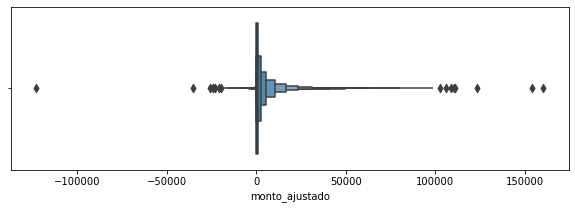

In [130]:
plt.figure(figsize=(10,3))
sns.boxenplot(data=df, x='monto_ajustado')

In [131]:
df['monto_ajustado'].describe().round(2)

count     65396.00
mean       1486.54
std        4458.57
min     -123027.27
25%          60.31
50%         247.06
75%        1076.04
max      160281.96
Name: monto_ajustado, dtype: float64

In [132]:
print('0.5% <', df['monto_ajustado'].quantile(.005))
print('1% <', df['monto_ajustado'].quantile(.01))
print('5% <', df['monto_ajustado'].quantile(.05))
print('10% <', df['monto_ajustado'].quantile(.1))

0.5% < -675.3012499999999
1% < -251.7
5% < 0.09
10% < 8.49


In [133]:
print('10% >', df['monto_ajustado'].quantile(.90))
print('5% >', df['monto_ajustado'].quantile(.95))
print('1% >', df['monto_ajustado'].quantile(.99))
print('0.5% >', df['monto_ajustado'].quantile(.995))
print('0.05% >', df['monto_ajustado'].quantile(.9995))

10% > 3478.795
5% > 6934.2525000000005
1% > 20647.90350000004
0.5% > 27766.07425000007
0.05% > 63712.32592500166


Observamos que existe una muy baja probabilidad de que un cliente tenga consumos mayores a 63712 pesos, por lo que decidimos eliminar outliers por la derecha de ese valor.

Al existir consumos negativos que se corresponden (cancelan) con otros positivos, tomamos la decisión de eliminar outliers negativos usando el mismo limite con el que eliminamos outliers en el lado derecho.

In [134]:
df[df['monto_ajustado'] > 63712].shape

(33, 41)

In [135]:
df[df['monto_ajustado'] < -63712].shape

(1, 41)

<AxesSubplot:xlabel='monto_ajustado'>

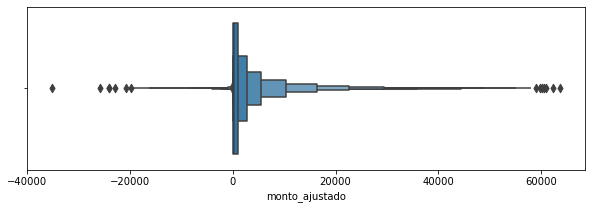

In [136]:
plt.figure(figsize=(10,3))
sns.boxenplot(data=df[(df['monto_ajustado'] < 63934.11) & (df['monto_ajustado'] > -63934.11)], x='monto_ajustado')

##### Valores atípicos en edad_cliente

<AxesSubplot:xlabel='edad_cliente'>

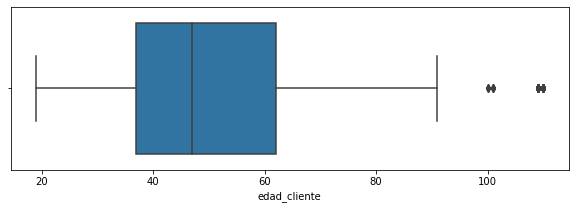

In [137]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df, x='edad_cliente')

In [138]:
print('0.5% <', df['edad_cliente'].quantile(.005))
print('1% <', df['edad_cliente'].quantile(.01))
print('5% <', df['edad_cliente'].quantile(.05))
print('10% <', df['edad_cliente'].quantile(.1))
print('10% >', df['edad_cliente'].quantile(.90))
print('5% >', df['edad_cliente'].quantile(.95))
print('1% >', df['edad_cliente'].quantile(.99))
print('0.5% >', df['edad_cliente'].quantile(.995))

0.5% < 24.0
1% < 26.0
5% < 28.0
10% < 31.0
10% > 71.0
5% > 75.0
1% > 81.0
0.5% > 85.0


In [139]:
df[df['edad_cliente'] < 24].edad_cliente.value_counts()

22.0    162
21.0     68
19.0     40
23.0     25
20.0     12
Name: edad_cliente, dtype: int64

In [140]:
df[df['edad_cliente'] > 85].edad_cliente.value_counts()

88.0     65
109.0    54
91.0     50
89.0     48
86.0     24
110.0    23
101.0     6
87.0      6
100.0     4
Name: edad_cliente, dtype: int64

Observamos que existen edades en ambos extremos con muy baja probabilidad de ocurrencia. Decidimos entonces, eliminar del dataset aquellas filas que correspondan a clientes mayores a 85 años y menores a 24.

Filas elminadas: 587


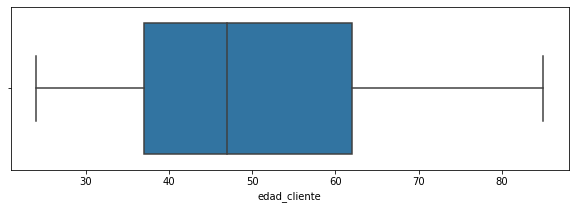

In [141]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df[(df['edad_cliente'] >= 24) & (df['edad_cliente'] <= 85)], x='edad_cliente')
print('Filas elminadas:', len(df[(df['edad_cliente'] < 24) | (df['edad_cliente'] > 85)]))

##### Valores atípicos en antig_cliente

<AxesSubplot:xlabel='antig_cliente'>

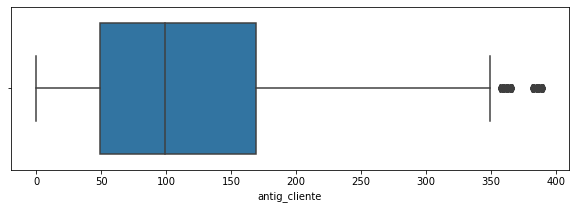

In [142]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df, x='antig_cliente')

In [143]:
print('10% >', df['antig_cliente'].quantile(.90))
print('5% >', df['antig_cliente'].quantile(.95))
print('1% >', df['antig_cliente'].quantile(.99))
print('0.5% >', df['antig_cliente'].quantile(.995))

10% > 241.0
5% > 269.0
1% > 288.0
0.5% > 304.0


In [144]:
df[df['antig_cliente'] > 304].antig_cliente.value_counts()

306    29
307    27
305    24
308    14
387    13
358    13
359    13
360    13
382    11
340     9
362     8
364     8
363     7
383     7
341     7
365     6
357     6
311     6
386     6
389     5
361     5
366     5
385     5
314     5
390     4
388     4
384     4
381     4
312     3
313     3
339     2
333     2
344     1
318     1
309     1
349     1
348     1
315     1
316     1
317     1
319     1
345     1
320     1
321     1
334     1
335     1
336     1
337     1
338     1
347     1
346     1
342     1
343     1
Name: antig_cliente, dtype: int64

Observamos que existen cuentas con antigüedad en el extremo derecho con muy baja probabilidad de ocurrencia. Decidimos entonces, eliminar del dataset aquellas filas que correspondan a clientes con antigüedad mayor a 304.

Filas elminadas: 299


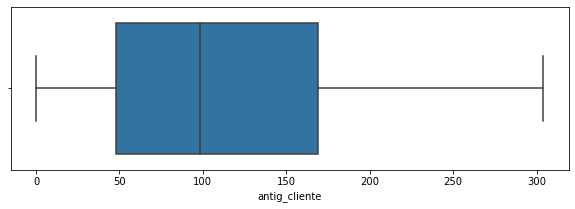

In [145]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df[df['antig_cliente'] <= 304], x='antig_cliente')
print('Filas elminadas:', len(df[df['antig_cliente'] > 304]))

#### Variables categoricas (Reagrupación)

##### Estado Civil

In [146]:
df.estado_civil_descripcion.value_counts()

Solteroa               31621
Casadoa                24970
Divorciadoa             2592
Viudoa                  2377
Separacion de hecho     1460
Concubinoa              1438
Sin Datos                863
Novioa                    75
Name: estado_civil_descripcion, dtype: int64

Observamos que existe una alta frecuencia en las categorías Solteros y Casados, perdiendo representativadad en el resto de los estados civiles, por lo cual decidimos agrupar a la mismas en una misma categoría.

In [147]:
soltero = ['Solteroa']
casado = ['Casadoa']
otros = ['Divorciadoa','Viudoa','Concubinoa','Separacion de hecho','Novioa']
sin_datos = ['Sin Datos']

df.loc[df['estado_civil_descripcion'].str.contains('|'.join(soltero)),'estado_civil_cat'] = 'Soltero'
df.loc[df['estado_civil_descripcion'].str.contains('|'.join(casado)),'estado_civil_cat'] = 'Casado'
df.loc[df['estado_civil_descripcion'].str.contains('|'.join(otros)),'estado_civil_cat'] = 'Otros'
df.loc[df['estado_civil_descripcion'].str.contains('|'.join(sin_datos)),'estado_civil_cat'] = 'Sin_datos'

In [148]:
df.estado_civil_cat.value_counts()

Soltero      31621
Casado       24970
Otros         7942
Sin_datos      863
Name: estado_civil_cat, dtype: int64

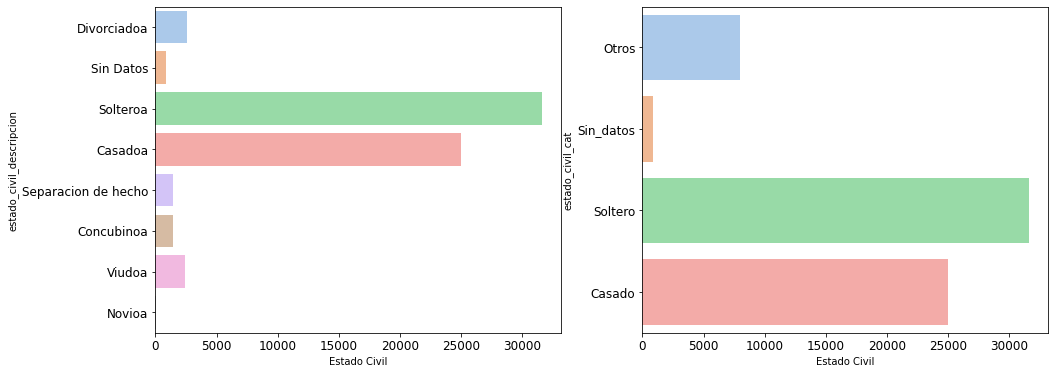

In [149]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))
g = sns.countplot(y=df.estado_civil_descripcion, ax=axes[0],palette="pastel")
g =  sns.countplot(y=df.estado_civil_cat, ax=axes[1],palette="pastel")

for ax in axes:
    ax.tick_params(labelsize=12)
    ax.set_xlabel("Estado Civil")

##### Provincias por Regiones

In [150]:
df[['provincia']].groupby(by=['provincia']).size()\
                .to_frame()\
                .reset_index(level=['provincia'])\
                .rename(columns = {0:'Cantidad_Transacciones'})\
                .sort_values(by='Cantidad_Transacciones',ascending=False)

,provincia,Cantidad_Transacciones
5,CORDOBA,12799
0,BUENOS AIRES,10340
24,TUCUMAN,4755
20,SANTA FE,4694
12,MENDOZA,4326
4,CHUBUT,2701
3,CHACO,2482
6,CORRIENTES,2453
1,CAPITAL FEDERAL,1974
16,SALTA,1937


Viendo las frecuencias por provincias, vamos a recategorizar sobre una nueva columna, las provincias por regiones.

In [151]:
dic_region = {'REGION_NOROESTE': ['JUJUY','SALTA','TUCUMAN','CATAMARCA','SGO DEL ESTERO'],
              'REGION_NORDESTE': ['CHACO','FORMOSA','CORRIENTES','MISIONES'], 
              'REGION_PAMPEANA': ['CORDOBA','BUENOS AIRES','CAPITAL FEDERAL','ENTRE RIOS','LA PAMPA','SANTA FE'], 
              'REGION_CUYO': ['SAN JUAN','SAN LUIS','LA RIOJA','MENDOZA'], 
              'REGION_PATAGONIA': ['SANTA CRUZ','TIERRA DEL FUEGO','RIO NEGRO','NEUQUEN','CHUBUT'],
              'SIN_DATOS': ['Sin Datos']}

df['region']= df['provincia']
for i in dic_region:
    df['region'] = df['region'].replace(dic_region[i], i)
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Propia,202008,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61.0,92,0,Otros,REGION_PAMPEANA
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Sin Datos,202008,15.68,INTERES POR MORA US,Sector_Sin_Datos,29.0,2,0,Sin_datos,REGION_CUYO
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Otros,202008,5.46,INTERES POR MORA US,Sector_Sin_Datos,28.0,95,0,Soltero,REGION_PAMPEANA
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Propia,202008,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40.0,151,0,Soltero,REGION_PAMPEANA
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,...,Alquilada,202008,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36.0,87,0,Soltero,REGION_PAMPEANA


In [152]:
df[['region']].groupby(by=['region']).size()

region
REGION_CUYO          7842
REGION_NORDESTE      7414
REGION_NOROESTE     11135
REGION_PAMPEANA     32052
REGION_PATAGONIA     6454
SIN_DATOS             499
dtype: int64

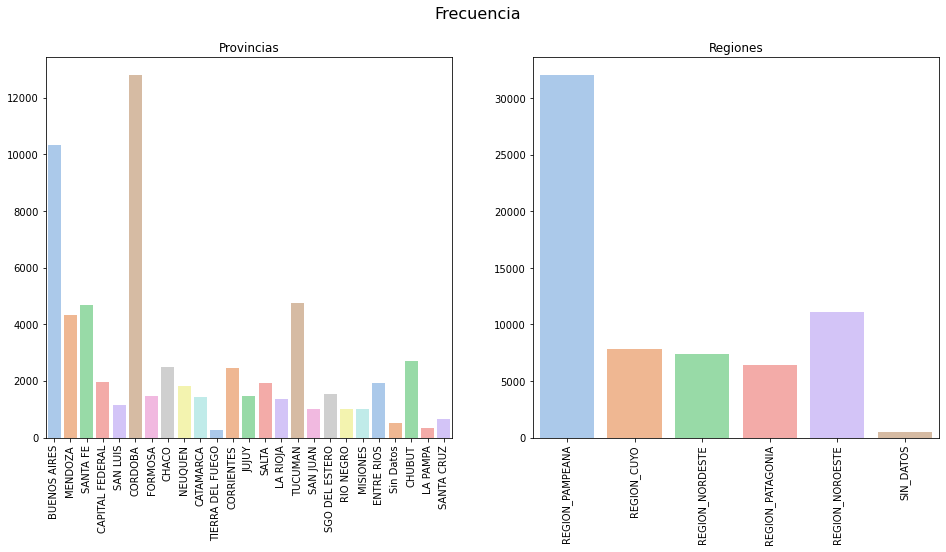

In [153]:
fig, axes = plt.subplots(1, 2,figsize=(16, 7))

sns.countplot(data=df, x='provincia', ax=axes[0], palette='pastel')
axes[0].title.set_text('Provincias')
axes[0].tick_params('x', rotation=90)
sns.countplot(data=df, x='region', ax=axes[1], palette='pastel')
axes[1].title.set_text('Regiones')
axes[1].tick_params('x', rotation=90)

axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlabel('')

fig.suptitle('Frecuencia', fontsize=16)
plt.show()

#### Fechas

Veremos las relaciones entre las distintas columnas de fecha para ver si podemos descartar algunas.

Text(0.5, 1.0, 'Histograma de frecuencia para fecha de cupón')

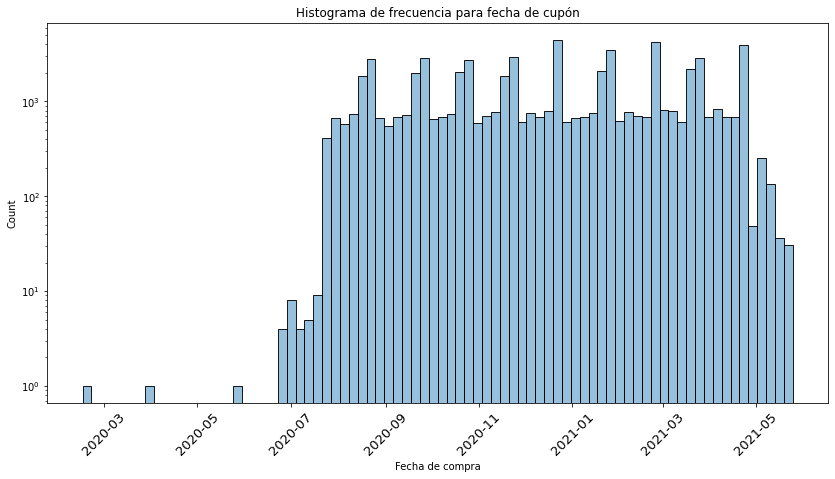

In [154]:
fecha = 'fecha_cupon_movimiento'

fig, ax = plt.subplots(figsize=(14,7))
ax.tick_params(axis='x',rotation = 45,labelsize = 13)
ax.set_xlabel("Fecha de compra")
ax.set_yscale("log")
sns.histplot(data=df, x=fecha, bins=80, color="#3182bd", alpha=0.5)
ax.set_title('Histograma de frecuencia para fecha de cupón')

In [155]:
print('Cantidad de casos antes de Abril 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-04-01')]))
print('Cantidad de casos antes de Mayo 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-05-01')]))
print('Cantidad de casos antes de Junio 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-06-01')]))
print('Cantidad de casos antes de Julio 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-07-01')]))
print('Cantidad de casos antes de Agosto 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-08-01')]))

Cantidad de casos antes de Abril 2020: 1
Cantidad de casos antes de Mayo 2020: 2
Cantidad de casos antes de Junio 2020: 3
Cantidad de casos antes de Julio 2020: 8
Cantidad de casos antes de Agosto 2020: 910


In [156]:
print('Cantidad de casos despues de Abril 2021:', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-04-01')]))
print('Cantidad de casos despues de Mayo 2021:', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-05-01')]))
print('Cantidad de casos despues de Junio 2021:', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-06-01')]))

Cantidad de casos despues de Abril 2021: 6708
Cantidad de casos despues de Mayo 2021: 453
Cantidad de casos despues de Junio 2021: 0


Desde Julio del 2020, la cantidad de transacciones aumenta significativamente en comparación con meses anteriores. Decidimos conservar solo los meses donde haya suficiente representacion de casos.

Haciendo un cálculo similar a los ultimos meses analizados, vemos que Mayo y Abril del 2021 están bien representados, por lo que se decide conservarlos.

In [157]:
df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-07-01')]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,...,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
25947,0005e599adf902c15aba4890e5c21dbf100,0,020099902,COMISION POR MANTENIMDE CTA,999990,1,PL,1,0,1,...,Propia,202006,-277.69,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,71.0,32,0,Casado,REGION_PAMPEANA
45505,0005e599adf902c15aba4890e5c21dbf100,0,020089993,IMPUESTO SELLOS,899999,1,PL,1,0,1,...,Propia,202006,-17.49,IMPUESTO SELLOS,Sector_Sin_Datos,71.0,32,0,Casado,REGION_PAMPEANA
57246,0005e599adf902c15aba4890e5c21dbf100,0,020099745,SERVICIO NARANJA A CELULARES,999991,1,SM,1,0,1,...,Propia,202006,-49.07,SERVICIO NARANJA A CELULARES,Sector_Sin_Datos,71.0,32,0,Casado,REGION_PAMPEANA
60789,0001397b9f75bd60336af6fb42f5002a384,0,010099058,TARJETA NARANJA SUCRE,121,0,PL,1,0,1,...,Propia,202004,954.96,TARJETA NARANJA SUCRE,Sector_Sin_Datos,45.0,166,0,Casado,REGION_NOROESTE
85976,00017c577769060500211670502411b5913,3,555059584,MERCADO PAGO,5510,0,PL,1,0,1,...,Propia,202005,1998.15,MERCADO PAGO,Sector_Operativo,62.0,77,5,Casado,REGION_NORDESTE
101507,00017c577769060500211670502411b5913,0,958705120,VISA CONSUMO,2949,1,VI,1,22,1,...,Propia,202006,-5205.83,VISA CONSUMO,Sector_Operativo,62.0,78,9,Casado,REGION_NORDESTE
103895,0009d755757673758d8a50f3e0a7d346850,0,958705138,VISA DEBITO AUTOMATICO,11323,0,VI,1,22,1,...,De familiar,202006,1563.23,VISA DEBITO AUTOMATICO,Sector_Empleado_Comercio,54.0,176,9,Soltero,REGION_PATAGONIA
124314,000986998f686d538f893956e736fedf611,3,350071053,20 DE MAYO SRL,70,0,PL,1,0,1,...,Propia,202002,1040.00,20 DE MAYO SRL,Sector_Operativo,45.0,261,3,Casado,REGION_CUYO


/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


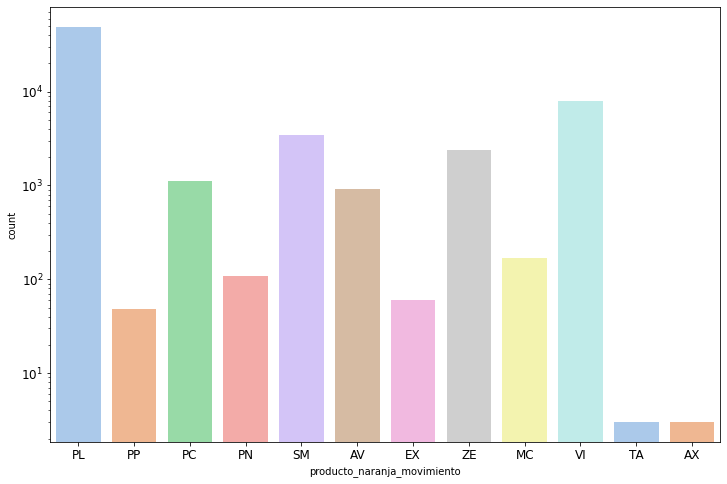

In [158]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(df['producto_naranja_movimiento'], palette="pastel")
ax.tick_params(labelsize=12)
ax.set_yscale('log')

In [159]:
df_prod = df['producto_naranja_movimiento'].value_counts().to_frame().reset_index().rename(
                                    {'index':'producto_naranja_movimiento',
                                     'producto_naranja_movimiento':'frecuencia_pr'}, axis=1)

df_prod_dni = pd.DataFrame(df.groupby(['producto_naranja_movimiento'])['dni_titular_movimiento'].nunique() \
                            .sort_values(ascending=True)) \
                            .reset_index()

df_prod_dni = df_prod_dni.merge(df_prod, on='producto_naranja_movimiento', how='inner')
df_prod_dni

,producto_naranja_movimiento,dni_titular_movimiento,frecuencia_pr
0,AX,2,3
1,TA,2,3
2,EX,4,60
3,MC,20,169
4,PP,25,48
5,PN,59,109
6,AV,116,907
7,PC,281,1123
8,SM,388,3475
9,VI,441,7923


Productos:

* PL: Plan largo 
* ZE: Zeta
* VI: Visa
* SM: Mensajes de texto a celulares
* PC: Plan de Cuotas
* AV: Revista Convivimos
* PN: Prestamos Personales PN
* PP: Plan de Pago Propuesto
* MC: MasterCard
* EX: Extraccion de Cajeros Nacionales
* TA: Transferencia Naranja Arg.
* AX: American Express

Eliminamos del dataset aquellas transacciones que corresponden a productos con importes constantes. No sufren modificaciones en el tiempo por lo tanto no es necesario predecir el monto.

Estas serian: 

- SM
- AV

#### Elimniacion de outliers

In [160]:
df = df[(df['monto_ajustado'] > -63712) & (df['monto_ajustado'] < 63712)]

df = df[(df['edad_cliente'] <= 85) & (df['edad_cliente'] >= 24)]

df = df[df['antig_cliente'] <= 304]

df = df[df['fecha_cupon_movimiento'] > pd.to_datetime('2020-07-01')]

df = df[~df['producto_naranja_movimiento'].isin(['AV','SM'])]

In [161]:
df.shape

(60151, 43)

### 3.3 Normalización de antiguedad y/o monto_compra_movimiento

In [162]:
from sklearn.preprocessing import Normalizer

x_test = df[["monto_ajustado","antig_cliente"]].values #returns a numpy array
transformer = Normalizer(norm='l1').fit(x_test)
x_norm = transformer.transform(x_test)
dff = pd.DataFrame(x_norm).rename(columns={0: 'monto_ajustado', 1: 'antig_cliente'})

In [163]:
dff

,monto_ajustado,antig_cliente
0,0.056604,0.943396
1,0.886878,0.113122
2,0.054350,0.945650
3,0.016287,0.983713
4,0.023569,0.976431
...,...,...
60146,0.990465,0.009535
60147,0.995202,0.004798
60148,0.992115,0.007885
60149,0.465098,0.534902


In [164]:
#scaled_df = pd.DataFrame(
colums_norm = ["monto_compra_movimiento","antig_cliente"] 
df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df[colums_norm])).rename(columns={'0': 'monto_compra_movimiento', '1': 'antig_cliente'})
df_scaled 

,0,1
0,-0.374898,-0.272978
1,-0.372706,-1.429489
2,-0.374910,-0.234428
3,-0.375549,0.485179
4,-0.375635,-0.337229
...,...,...
60146,2.330386,-0.260128
60147,5.319030,-0.195877
60148,3.324803,-0.105926
60149,-0.341987,0.343828


In [165]:
monto = df.monto_ajustado.values.copy()
antig = df.antig_cliente.values.copy()
monto_norm = dff.monto_ajustado
antig_norm = dff.antig_cliente

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Monto normalizado')

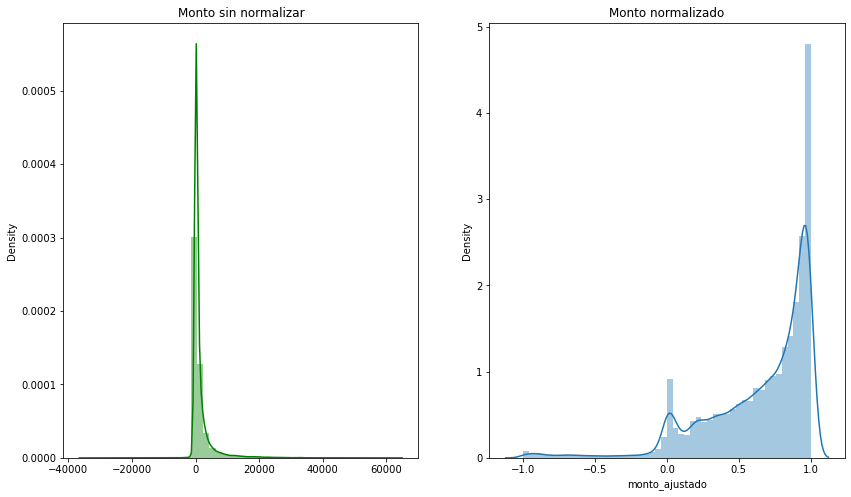

In [166]:
fig, ax=plt.subplots(1,2, figsize=(14,8))
sns.distplot(monto,ax=ax[0],color='Green')
ax[0].set_title("Monto sin normalizar")
sns.distplot(monto_norm, ax=ax[1])
ax[1].set_title("Monto normalizado")

Podemos observar que la distribución de la variable transformada difiere mucho de la normal. Los consumos de los clientes no necesariamente se van a distribuir de manera normal. Uno de los objetivos de esta mentoria es encontrar clusters de consumo, por lo cual partimos de la premisa de que no vamos a tener una distribucion normal donde la media represente de manera significativa a todos los clientes. Por lo tanto transformar esta distribucion a una normal no nos parece conveniente.

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Antiguedad normalizada')

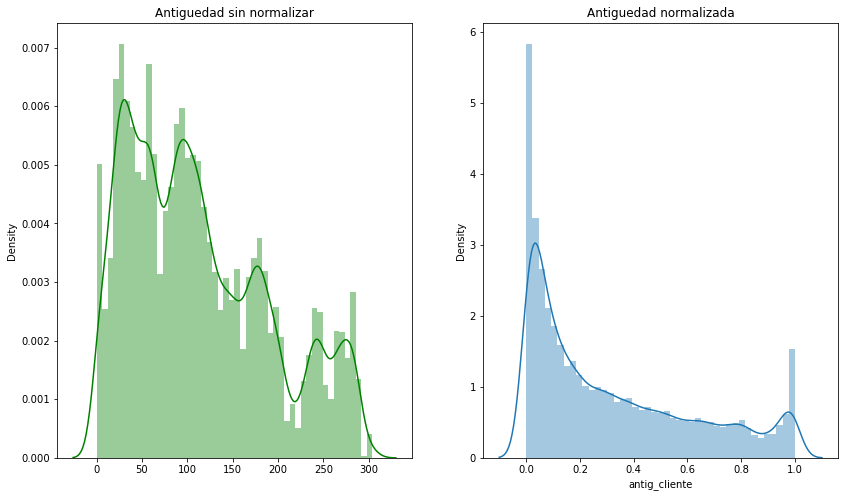

In [167]:
fig, ax=plt.subplots(1,2, figsize=(14,8))
sns.distplot(antig,ax=ax[0],color='Green')
ax[0].set_title("Antiguedad sin normalizar")
sns.distplot(antig_norm, ax=ax[1])
ax[1].set_title("Antiguedad normalizada")

Observamos que la distribución que resulta de esta transformacion no se parece a una normal. Por lo tanto, concluimos que se pierde mucha información y las ganancias obtenidas son bajas. Decidimos entonces, conservar la distribución original de esta variable.

### 3.4.1 Seleccion de columnas a utilizar

#### Calculos de correlaciones numéricas

In [168]:
print('fecha_cupon vs fecha_presentacion:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df["fecha_presentacion_movimiento"].dt.date, method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_presentacion:


0.9987196108920707

In [169]:
print('fecha_cupon vs fecha_vto:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df['fecha_vto_cupon_movimiento'].dt.date, method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_vto:


0.9898196657597929

In [170]:
df[["monto_compra_movimiento", "importe_cuota_movimiento"]].corr()

,monto_compra_movimiento,importe_cuota_movimiento
monto_compra_movimiento,1.000000,0.992954
importe_cuota_movimiento,0.992954,1.000000


In [171]:
df[["id_comercio_otras_marcas_movimiento", "id_comercio_movimiento"]].corr()

,id_comercio_otras_marcas_movimiento
id_comercio_otras_marcas_movimiento,1.0


In [172]:
df[["local_venta_producto", "id_comercio_movimiento"]].corr()

,local_venta_producto
local_venta_producto,1.0


In [173]:
df.groupby(['nivel_estudio_descripcion_histo'])['monto_ajustado'].describe().round(2).sort_values(by="nivel_estudio_descripcion_histo", ascending=True)

,count,mean,std,min,25%,50%,75%,max
nivel_estudio_descripcion_histo,,,,,,,,
PRIMARIOS,14577.0,1466.27,4011.94,-20778.07,66.58,245.15,1134.15,63616.14
SECUNDARIOS,32017.0,1569.07,4233.68,-35117.69,78.77,259.96,1175.57,62261.25
Sin Datos,2146.0,1409.37,3090.67,-19656.46,110.35,318.55,1377.52,47618.21
TERCIARIOS,7142.0,1619.54,4001.50,-24125.31,97.60,303.39,1430.95,47258.36
UNIVERSITARIOS,4269.0,1615.10,3881.39,-12454.50,105.78,295.74,1364.08,58939.82


In [174]:
df.groupby(['rel_vivienda_descripcion_histo'])['monto_ajustado'].describe().round(2).sort_values(by="rel_vivienda_descripcion_histo", ascending=True)

,count,mean,std,min,25%,50%,75%,max
rel_vivienda_descripcion_histo,,,,,,,,
Alquilada,2069.0,1594.13,4150.15,-12997.97,79.38,298.09,1322.21,57272.62
De familiar,4997.0,1660.95,4323.55,-35117.69,97.56,278.55,1490.08,60210.74
Otros,4851.0,1606.40,3936.46,-4278.96,73.49,256.20,1464.28,55161.54
Propia,41828.0,1512.67,4054.04,-25775.87,80.58,259.96,1150.97,63616.14
Sin Datos,6406.0,1628.82,4256.13,-19656.46,75.04,259.94,1210.03,62261.25


#### Analisis descriptivo por columna

Algunas columnas se eliminaron en analisis anteriores. Procedemos a seleccionar las columnas que mejor nos ayudaran a predecir la próxima compra

* **dni_titular_movimiento: Se conserva por ser ID único de cliente**
* **moneda_movimiento: Se conserva para identificar consumos en moneda extranjera**
* id_comercio_movimiento: Se descarta porque conservamos comercio_cat que surge a partir de esta misma variable
* nombre_comercio_histo: Se descarta por usar comercio_cat
* numero_cupon_movimiento: Se descarta por no aportar informacion util a la predicción de la compra
* debito_credito_movimiento: Solo permite diferenciar movimientos positivos de negativos, informacion presente en la variable monto.
* **producto_naranja_movimiento: Se conserva**
* codigo_empresa_movimiento: Se descarta por no aportar informacion util a la predicción de la compra
* **tipo_producto_tarjeta_movimiento: Se conserva**
* plan_movimiento: Se descarta por no aportar informacion util a la predicción de la compra
* **fecha_cupon_movimiento: Se conserva**
* monto_compra_movimiento: Se descarta, ya que se conserva monto_ajustado, que es el resultado de su transformación
* importe_cuota_movimiento: Se descarta por su fuerte correlación con monto_compra_movimiento
* interes_movimiento: Se descarta por su falta de datos significativos
* cargo_adm_seguro_movimiento, cargo_otorgamiento_movimiento, cargo_seguro_vida_movimiento, cargo_administrativo_movimiento: Se descartan por tener mayoria de datos en 0.
* seleccionado_ng: Se descarta por no representar nada significativo
* codigo_contable_movimiento: Se descarta por su baja interpretabilidad
* local_venta_producto: Se descarta por aportar la misma información que id_comercio_movimiento
* marca_debito_automatico: Se descarta por no aportar informacion util a la predicción de la compra
* id_comercio_otras_marcas_movimiento: Se descarta por tener mayoria de datos en 0 y una correlación fuerte con id_comercio
* estado_civil_descripcion: Se descarta por recategorización
* **sexo_descripcion: Se conserva**  
* provincia: Se descarta por recategorizacion en regiones
* ciudad: Se descarta para tener un analisis geografico limitado hasta regiones
* domicilio_codigo_postal: Se descarta para tener un analisis geografico limitado hasta regiones
* fecha_de_ingreso_histo: Se descarta porque su único objetivo era calcular la antigüedad del cliente
* fecha_presentacion_movimiento: Se descarta por su fuerte correlación con fecha_cupon_movimiento
* fecha_vto_cupon_movimiento: Se descarta por su fuerte correlación con fecha_cupon_movimiento
* cargo_descripcion_histo: Se descarta por recategorizacion
* nivel_estudio_descripcion_histo: Se descarta por tener distribuciones parecidas para cada categoría
* rel_vivienda_descripcion_histo: Se descarta por tener distribuciones parecidas para cada categoría

In [175]:
df_final = df[['dni_titular_movimiento', 'fecha_cupon_movimiento', 'moneda_movimiento', 'producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento',
               'anio_mes_cupon', 'sexo_descripcion', 'monto_ajustado',
               'cargo_sector_desc_hist', 'edad_cliente', 'antig_cliente', 'comercio_cat', 
               'estado_civil_cat', 'region']]

In [176]:
df_final.shape

(60151, 14)

In [177]:
df_final

,dni_titular_movimiento,fecha_cupon_movimiento,moneda_movimiento,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,anio_mes_cupon,sexo_descripcion,monto_ajustado,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
0,0001686b52949b5461ffcbc766687e45031,2020-08-25,0,PL,0,202008,Hombre,5.52,Sector_Empleado_Comercio,61.0,92,0,Otros,REGION_PAMPEANA
1,000220fa96ec5af89817894033f8099c547,2020-08-25,0,PL,0,202008,Mujer,15.68,Sector_Sin_Datos,29.0,2,0,Sin_datos,REGION_CUYO
2,0002be202de47dfae9cc2304d91161be595,2020-08-25,0,PL,0,202008,Mujer,5.46,Sector_Sin_Datos,28.0,95,0,Soltero,REGION_PAMPEANA
3,000e137d0af42e193be1ff670c00d4d1506,2020-08-25,0,PL,0,202008,Hombre,2.50,Sector_Empleado_Comercio,40.0,151,0,Soltero,REGION_PAMPEANA
4,0009d010e4faf69552a814a33832b185877,2020-08-25,0,PL,0,202008,Mujer,2.10,Sector_Empleado_Comercio,36.0,87,0,Soltero,REGION_PAMPEANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124306,0002716f6d9c2130a8c88a0219de234d459,2021-05-14,0,PC,3,202105,Mujer,9661.01,Sector_No_Operativo,46.0,93,0,Soltero,REGION_NOROESTE
124309,0001f61dd2845a7e653ebfdaf22dab3b373,2021-05-14,0,PC,3,202105,Mujer,20329.24,Sector_Empleado_Comercio,48.0,98,0,Casado,REGION_PATAGONIA
124311,0006c15ca823454b68c189da1344d9d7317,2021-05-14,0,PC,3,202105,Hombre,13210.67,Sector_No_Operativo,66.0,105,0,Casado,REGION_NORDESTE
124312,0000ab27a0ed815f947df8bcb834ff97975,2021-05-03,0,PC,3,202105,Hombre,121.73,Sector_Empleado_Comercio,74.0,140,0,Soltero,REGION_NOROESTE


Eliminamos duplicados una ultima vez luego de la selección

In [178]:
df_final = df_final[~df_final.duplicated()]

In [179]:
df_final.isna().sum()

dni_titular_movimiento              0
fecha_cupon_movimiento              0
moneda_movimiento                   0
producto_naranja_movimiento         0
tipo_producto_tarjeta_movimiento    0
anio_mes_cupon                      0
sexo_descripcion                    0
monto_ajustado                      0
cargo_sector_desc_hist              0
edad_cliente                        0
antig_cliente                       0
comercio_cat                        0
estado_civil_cat                    0
region                              0
dtype: int64

In [180]:
df_final.shape

(53844, 14)

## Consideraciones en el tratamiento de las variables

Tanto en clasificación como en regresión, el dataset debe ser codificado y agrupado por mes según criterios impuestos por nuestro mentor. El target en regresión es el monto_ajustado, y en clasificacion es una variable nueva, fg_aumentado, que se crea en el trabajo practico 3.

En las celdas siguientes, realizamos operaciones de codificación y agrupación, donde se sumariza el total de consumos del cliente en un mes. Por un lado, sumarizamos las variables que representan información sobre la transacción, y, por otro lado, usamos la funcion max para obtener el valor de las columnas que identifican al cliente, ya que no cambia en el transcurso de un mes.

### Seleccion de columnas

Veamos los tipos de columnas que tenemos, pensandolo en punto de vista de entrada hacia los modelos de clasificación y regresión:
- **Variable ordinal**: dni_titular_movimiento. Identifica univocamente al cliente. Al ser ordinal debe excluirse como feature
- **target de regresion**: monto_ajustado
- **features numericas de la transaccion**: anio_mes_cupon y fecha_cupon. Se sumarizan al momento de agrupar y luego son escaladas
- **features numericas del cliente**: edad y antiguedad. Se maximizan al momento de agrupar (no cambian su valor) y luego son escaladas
- **features categoricas de la transaccion**: producto, tio, moneda y comercio. Se codifican, luego se sumarizan al momento de agrupar y luego son escaladas.
- **features categoricas del cliente**: Se codifican, y luego se maximizan al momento de agrupar



### Codificación

In [230]:
ordinal_ft = 'dni_titular_movimiento'
target = 'monto_ajustado'
#date_num = 'anio_mes_cupon'
num_features = ['anio_mes_cupon', 'edad_cliente', 'antig_cliente', 'fecha_cupon_movimiento']
trans_ft = ['producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento', 'moneda_movimiento', 'comercio_cat']
client_ft = ['sexo_descripcion', 'cargo_sector_desc_hist', 'estado_civil_cat', 'region']

In [231]:
# Cambiamos los valores para moneda y 

dic_tipo_prod = {42: 'American_express', 44: 'American_express_gold', 0: 'Clasica', 32: 'Master_internacional',
    31: 'Master_nacional', 3: 'Naranja', 4: 'Naranja_virtual', 24: 'Naranja_visa_mini_int', 23: 'Naranja_visa_mini_nac',
    12: 'Naranja_visa_internac.', 11: 'Naranja_visa_nacional', -1: 'Sin_Datos', 22: 'Visa_internacional', 21: 'Visa_nacional'}
dic_monedas = {0: 'Pesos',1: 'Dolares',3: 'Zeta'}
df_final.tipo_producto_tarjeta_movimiento = df_final.tipo_producto_tarjeta_movimiento.replace(dic_tipo_prod)
df_final.moneda_movimiento = df_final.moneda_movimiento.replace(dic_monedas)

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [237]:
# Ordenamos por fecha
df = df_final.sort_values(by = ['fecha_cupon_movimiento'], ascending = True).copy()
# Transformacion de fecha a numerica
df['fecha_cupon_movimiento'] = df['fecha_cupon_movimiento'].values.astype(float)/10**11
# Transformacion de tipo de moneda a string
df['moneda_movimiento'] = df['moneda_movimiento'].astype(str)

# Codificación
cat_transformer = OneHotEncoder(handle_unknown='ignore')

encoder = ColumnTransformer(
    transformers=[
        ('dni', 'drop', [ordinal_ft]),
        ('num', 'passthrough', num_features),
   #     ('date_num', discretizer, [date_num]),
        ('trans', cat_transformer, trans_ft),
        ('client', cat_transformer, client_ft),
        ('target', 'passthrough', [target])])
df_enc = encoder.fit_transform(df)
cols = encoder.get_feature_names()

# Agregar feature ordinal al principio del dataframe

dff_enc = pd.DataFrame.sparse.from_spmatrix(df_enc, columns=[cols]).sparse.to_dense()
cols_o = np.hstack([[ordinal_ft],cols])
df_stack = np.hstack([df[[ordinal_ft]],dff_enc])
df_encode = pd.DataFrame(df_stack , columns=cols_o)

### Agrupación por Mes

Definimos distintas funciones de agregacion segun el tipo de feature definido anteriormente. Las features del cliente se mantienen en todo el dataset para cada cliente, por lo que aplicarles 'max' no significaria una perdida de informacion. Las columnas relacionadas a la transaccion se suman para contabilizar las transacciones para esa categoria en el mes que se va a agrupar.

In [184]:
# Renombramos
df_encode.rename({'edad_cliente':'client__edad',
                         'antig_cliente':'client__antig'}, axis=1, inplace=True)
cols = df_encode.columns

# Funciones de agregacion para cada columna
aggr = {} 
aggr.update(dict.fromkeys([x for x in cols if 'client__' in x], 'max')) # Incluye a edad y antiguedad
aggr.update(dict.fromkeys([x for x in cols if 'trans__' in x], 'sum'))
aggr.update({target:'sum'})

In [185]:
num_features = ['anio_mes_cupon', 'client__edad', 'client__antig', 'fecha_cupon_movimiento']

# Convertimos las columnas categoricas de la transaccion a numericas para poder sumarizarlas
df_encode[num_features + [x for x in cols if 'trans' in x]] = \
df_encode[num_features + [x for x in cols if 'trans' in x]].apply(pd.to_numeric)

# Agrupamiento
group = ['dni_titular_movimiento', 'anio_mes_cupon']

df_mes = df_encode.groupby(group).agg(aggr).reset_index() # edad y antiguedad

In [186]:
df_mes[df_mes['dni_titular_movimiento'] == '0000ab27a0ed815f947df8bcb834ff97975']

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
410,0000ab27a0ed815f947df8bcb834ff97975,202008.0,74.0,132.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,42771.31
411,0000ab27a0ed815f947df8bcb834ff97975,202009.0,74.0,133.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,788.94
412,0000ab27a0ed815f947df8bcb834ff97975,202010.0,74.0,134.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8860.46
413,0000ab27a0ed815f947df8bcb834ff97975,202011.0,74.0,135.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,901.05
414,0000ab27a0ed815f947df8bcb834ff97975,202012.0,74.0,136.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20483.75
415,0000ab27a0ed815f947df8bcb834ff97975,202101.0,74.0,137.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,521.44
416,0000ab27a0ed815f947df8bcb834ff97975,202102.0,74.0,138.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,712.41
417,0000ab27a0ed815f947df8bcb834ff97975,202103.0,74.0,139.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1044.05
418,0000ab27a0ed815f947df8bcb834ff97975,202104.0,74.0,140.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,838.91
419,0000ab27a0ed815f947df8bcb834ff97975,202105.0,74.0,140.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12405.89


### Guardado

Decidimos usar el formato 'parquet' para guardar el dataset, por ser mas liviano y rapido que csv

In [187]:
df_mes.to_parquet('df_supervisado_agrupado.parquet')

In [188]:
df_mes.columns

Index(['dni_titular_movimiento', 'anio_mes_cupon', 'client__edad',
       'client__antig', 'client__x0_Hombre', 'client__x0_Mujer',
       'client__x0_Sin Datos', 'client__x1_Sector_Educativo',
       'client__x1_Sector_Empleado_Comercio', 'client__x1_Sector_Financiero',
       'client__x1_Sector_No_Operativo', 'client__x1_Sector_Operativo',
       'client__x1_Sector_Salud', 'client__x1_Sector_Seguridad',
       'client__x1_Sector_Sin_Datos', 'client__x2_Casado', 'client__x2_Otros',
       'client__x2_Sin_datos', 'client__x2_Soltero', 'client__x3_REGION_CUYO',
       'client__x3_REGION_NORDESTE', 'client__x3_REGION_NOROESTE',
       'client__x3_REGION_PAMPEANA', 'client__x3_REGION_PATAGONIA',
       'client__x3_SIN_DATOS', 'trans__x0_AX', 'trans__x0_EX', 'trans__x0_MC',
       'trans__x0_PC', 'trans__x0_PL', 'trans__x0_PN', 'trans__x0_PP',
       'trans__x0_TA', 'trans__x0_VI', 'trans__x0_ZE',
       'trans__x1_American_express', 'trans__x1_Clasica',
       'trans__x1_Master_internacio

### 3.4.2 Análisis PCA

Primero se debe procesar las columnas antes de aplicar el PCA, es decir dejarlas en formato de matríz y estandarizarlas para el mejor uso del algoritmo.

In [207]:
colum_pca = ["monto_ajustado", "client__edad","client__antig"] 

In [208]:
df_pca = df_mes[colum_pca]

In [209]:
df_pca_stand = preprocessing.StandardScaler().fit_transform(df_pca)
df_pca_stand

array([[-0.79694892, -0.20730889,  1.57230044],
       [-0.7969415 , -0.14045252,  1.58559844],
       [-0.79693138, -0.14045252,  1.59889643],
       ...,
       [-0.61697162,  0.99610583, -1.11389467],
       [-0.48052403,  0.99610583, -1.10059667],
       [-0.65740006,  0.99610583, -1.08729868]])

In [210]:
pca2 = PCA(n_components=3)
pca2.fit(df_pca_stand)
proyected_features_2 = pca2.transform(df_pca_stand)
proyected_features_2.shape

(7410, 3)

In [211]:
explained_variance_2 = pca2.explained_variance_ratio_
explained_variance_2

array([0.4671865 , 0.32765221, 0.20516129])

In [212]:
acc_variance_percent_2 = np.cumsum(np.round(explained_variance_2, decimals=4) * 100)
acc_variance_percent_2

array([ 46.72,  79.49, 100.01])

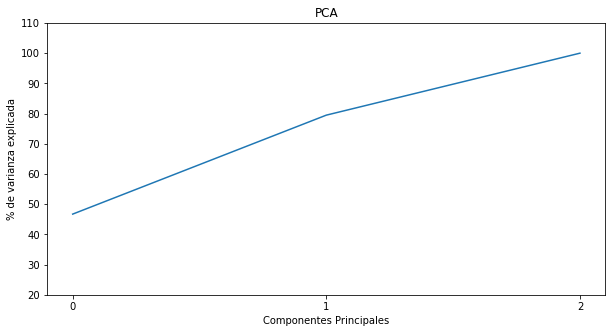

In [213]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(range(pca2.n_components))
plt.plot(acc_variance_percent_2)

Existen dos componentes principales que explican un 80.04% de la variabilidad de los datos.

In [214]:
df_pca_final = df_pca[colum_pca]
df_pca_final.loc[:,["pca1","pca2"]] = proyected_features_2[:,:2]
df_pca_final

,monto_ajustado,client__edad,client__antig,pca1,pca2
0,-4.72,46.0,225.0,0.743260,-0.765847
1,-4.61,47.0,226.0,0.796772,-0.788774
2,-4.46,47.0,227.0,0.806062,-0.789477
3,-4.34,47.0,228.0,0.815352,-0.790183
4,-4.21,47.0,229.0,0.824643,-0.790888
...,...,...,...,...,...
7405,11616.45,64.0,21.0,-0.141225,-0.282104
7406,12566.68,64.0,22.0,-0.114420,-0.222454
7407,2663.08,64.0,23.0,-0.287699,-0.852290
7408,4685.64,64.0,24.0,-0.241127,-0.724520


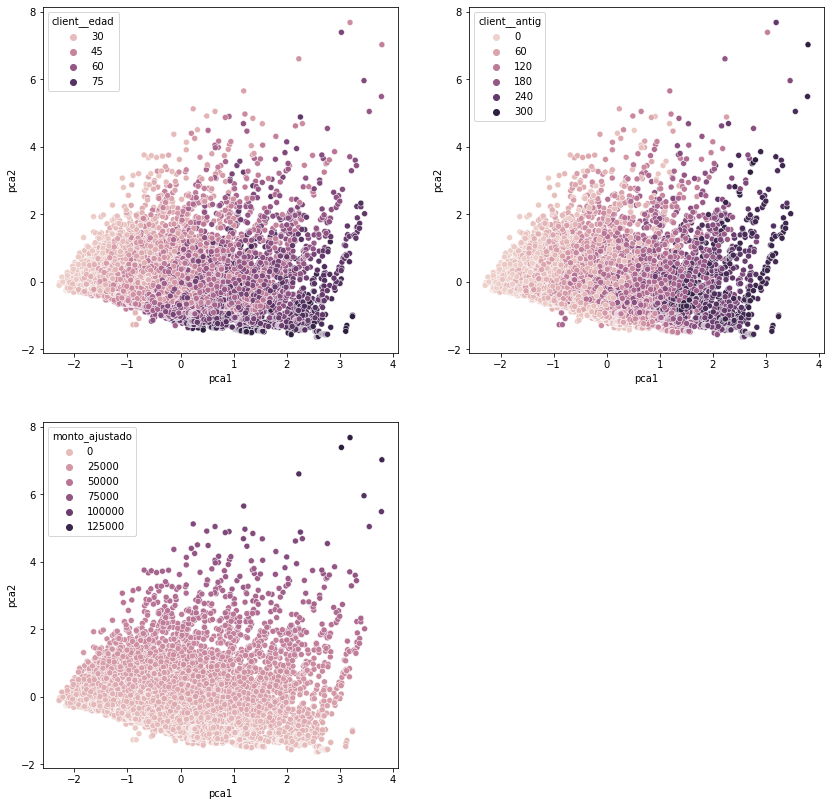

In [215]:
cols = ['client__edad', 'client__antig', 'monto_ajustado']
data = df_pca_final[cols + ['pca1', 'pca2']]
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='client__edad', ax=axes[0][0])  
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='client__antig', ax=axes[0][1]) 
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='monto_ajustado', ax=axes[1][0]) 
fig.delaxes(axes[1][1])

Sabemos que PCA es un metodo utilizado para reducir dimensionalidad. Aplica combinaciones lineales de las variables para obtener componentes principales que expliquen la variabilidad de los datos. 

En este caso, obtuvimos dos componentes principales que explican el 80.04% de la varianza. Al graficar estos componentes junto con los features originales, podemos observar lo siguiente:

- En los primeros dos graficos, el PCA1 parece aumentar conforme aumenta edad_cliente y antiguedad_cliente (de color violeta claro, a uno mas oscuro para valores mas altos de pca1). Por lo cual se podria concluir que PCA1 explica la variabilidad de los datos en funcion a estos features.  Sin embargo, pareciera haber algunas zonas donde el cambio no es gradual, sacandole continuidad al cambio en la variabilidad. 

- En el tercer grafico se puede observar que el comportamiento del feature monto_ajustado explica la variabilidad de los datos de una manera parecida a PCA2. La gradualidad de este cambio se ve de forma mas clara respecto a los graficos anteriores. 


Seria posible en base a esto, eliminar edad_cliente o antiguedad_cliente, ya que ambas son explicadas por el componente PCA1.

#### Union de las columnas resultantes de PCA

In [218]:
df_final = df_mes.merge(df_pca_final[['pca1', 'pca2']], left_index=True, right_index=True)
df_final.shape

(7410, 57)

In [219]:
df_final

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado,pca1,pca2
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72,0.743260,-0.765847
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61,0.796772,-0.788774
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46,0.806062,-0.789477
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34,0.815352,-0.790183
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012.0,47.0,229.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.21,0.824643,-0.790888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,000f0b73ebfa002a79a0642b82e87919904,202101.0,64.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11616.45,-0.141225,-0.282104
7406,000f0b73ebfa002a79a0642b82e87919904,202102.0,64.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12566.68,-0.114420,-0.222454
7407,000f0b73ebfa002a79a0642b82e87919904,202103.0,64.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2663.08,-0.287699,-0.852290
7408,000f0b73ebfa002a79a0642b82e87919904,202104.0,64.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4685.64,-0.241127,-0.724520


-----

FIN